In [1]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



def process_log_file(full_path):
    if os.stat(full_path).st_size == 0:
        print(f"Skipping empty file: {full_path}")
        return pd.DataFrame()

    with open(full_path, 'r') as file:
        data = []
        for line in file:
            match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+)\s+parallelism:(\d+)\s+concurrency:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:([\deE.-]+)', line)
            if match:
                time = datetime.fromtimestamp(float(match.group(1)))
                throughput = float(match.group(3))
                loss_rate = float(match.group(4))
                parallelism = int(match.group(5))
                concurrency = int(match.group(6))
                score = float(match.group(7))
                rtt = float(match.group(8))
                energy = float(match.group(9))
                sender_lr = float(match.group(10))

                data.append([time, throughput, loss_rate, parallelism, concurrency, score, rtt, energy, sender_lr])

        if data:
            df = pd.DataFrame(data, columns=['Time', 'Throughput', 'LossRate', 'Parallelism', 'Concurrency', 'Score', 'RTT', 'Energy', 'SenderLR'])
        else:
            df = pd.DataFrame()
            print(f"No valid data in file: {full_path}")

    return df

def process_directory(directory_path):
    all_dfs = []  # List to hold all DataFrames from each log file
    for filename in os.listdir(directory_path):
        # Construct the full path to the file
        full_path = os.path.join(directory_path, filename)
        # Check if it's a file and has a log extension (if your log files have a specific extension)
        if os.path.isfile(full_path):  # and filename.endswith(".log"):
            print(f"Processing file: {filename}")
            df = process_log_file(full_path)
            if not df.empty:
                all_dfs.append(df)
            else:
                print(f"Empty or invalid data in file: {filename}")

    # Concatenate all DataFrames if not empty
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was found

def print_empty_dataframes(dfs):
    total_rows=0
    for key, df in dfs.items():
        if df.empty:
            print(f"The DataFrame for key '{key}' is empty.")
        else:
            num_rows = len(df)
            total_rows+=num_rows
            print(f"The DataFrame for key '{key}' has {num_rows} rows")
    print(f"\n\n\nThere are toatl {total_rows} rows in all the transitions dictionaries")
    
    
import pandas as pd

def find_transitions_tuple_based(df, col1, col2, old_tuple, target_tuple):
    # Create a new empty DataFrame with the same columns
    new_df = pd.DataFrame(columns=df.columns)
    # Flag to mark if we are currently in a transition block
    in_transition = False
    # Iterate through the DataFrame
    for index, row in df.iterrows():
        # Check for transition start
        if row[col1] == old_tuple[0] and row[col2] == old_tuple[1] and not in_transition:
            in_transition = True
        # Check for transition end
        elif row[col1] == target_tuple[0] and row[col2] == target_tuple[1] and in_transition:
            new_df = new_df.append(row)
        # If the value is neither start nor target, reset the flag
        elif row[col1] != old_tuple[0] or row[col2] != old_tuple[1]:
            in_transition = False

    return new_df.reset_index(drop=True)


def filter_df_by_value_tuple(df_original, column_name_1, column_name_2, value_tuple):
    """
    Filters the DataFrame based on specific values in two given columns and creates an independent copy.

    :param df_original: The original DataFrame.
    :param column_name_1: The name of the first column to filter on.
    :param column_name_2: The name of the second column to filter on.
    :param value_tuple: A tuple containing the values to filter by in the specified columns.
    :return: A new DataFrame containing rows where each column matches its corresponding value in value_tuple.
    """
    filtered_df = df_original[(df_original[column_name_1] == value_tuple[0]) & (df_original[column_name_2] == value_tuple[1])].copy()
    return filtered_df



def sample_row_and_neighbors(df, column_name):
    """
    Samples a row based on the distribution of a specific column and returns it with its 4 neighboring rows.
    If fewer than 5 rows are returned, the function duplicates rows to ensure 5 rows are returned.

    :param df: The DataFrame to sample from.
    :param column_name: The column whose distribution to use for sampling.
    :return: A DataFrame containing the sampled row and its 4 neighbors, ensuring 5 rows in total.
    """
    # Ensure the DataFrame's index is reset
    df = df.reset_index(drop=True)
    # Calculate the frequency distribution of the column
    probabilities = df[column_name].value_counts(normalize=True)
    # Map these probabilities back to the DataFrame's index
    probabilities = df[column_name].map(probabilities)
    # Sample one row using these probabilities
    sampled_row = df.sample(n=1, weights=probabilities)
    sampled_index = sampled_row.index[0]

    # Ensure the sampled index is within the DataFrame's range
    if sampled_index >= len(df):
        raise ValueError("Sampled index is out of DataFrame's range.")

    # Attempt to select 2 neighbors from each side
    start_index = max(sampled_index - 2, 0)
    end_index = min(sampled_index + 2, len(df) - 1)
    selected_rows = df.iloc[start_index:end_index + 1]

    # If fewer than 5 rows are selected, duplicate rows to reach 5
    while len(selected_rows) < 5:
        if start_index > 0:
            start_index -= 1
        elif end_index < len(df) - 1:
            end_index += 1
        else:
            # If start and end indices cover the whole DataFrame, duplicate the last row
            selected_rows = pd.concat([selected_rows, selected_rows.iloc[[-1]]], ignore_index=True)
        # Update selected_rows if indices were adjusted
        if len(selected_rows) < 5:
            selected_rows = df.iloc[start_index:end_index + 1]

    return selected_rows


def normalize_and_flatten(df, min_values, max_values):
    # Drop the specified columns
    df = df.drop(columns=['Time'])
    score_array = df['Score'].values
    energy_array=df['Energy'].values
    throughput_array=df['Throughput'].values
#     print(df.describe())
    # Normalize each column
    normalized_df = (df - min_values) / (max_values - min_values)

    # Flatten the DataFrame to a single NumPy array
    flattened_array = normalized_df.values.flatten()

    return flattened_array,score_array,energy_array,throughput_array


In [2]:
!pwd

/home/jamilm/transferService/RL_agents/PPO_self_implementation


In [3]:
directory="/home/jamilm/transferService/RL_agents/PPO_self_implementation/logFileDir/PPO_MA/"
df=process_directory(directory)

Processing file: PPO_MA_logFile_02_04_2024_20_48_43.log


In [4]:

print("##################################################################")
print("Original df")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')


df= df[(df['Throughput'] != 0)]
df.reset_index(drop=True, inplace=True)
print("##################################################################")
print("df after removing throughput ==0 rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')


df= df[(df['Energy'] != 0)]
df.reset_index(drop=True, inplace=True)
print("##################################################################")
print("df after removing Energy ==0 rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')

##################################################################
Original df
##################################################################
          Throughput       LossRate    Parallelism    Concurrency  \
count  156277.000000  156277.000000  156277.000000  156277.000000   
mean        3.399627       0.000051       4.898833       4.876431   
std         3.303315       0.015256       2.145243       2.035325   
min         0.000000       0.000000       1.000000       1.000000   
25%         0.320000       0.000000       3.000000       3.000000   
50%         2.560000       0.000000       5.000000       5.000000   
75%         5.760000       0.000000       6.000000       6.000000   
max        17.600000       6.000000       8.000000       8.000000   

               Score            RTT         Energy       SenderLR  
count  156277.000000  156277.000000  156277.000000  156277.000000  
mean        3.176085      31.330766      58.280374       0.000597  
std         3.437546       7

In [5]:
# Creating a Series of tuples from 'column1' and 'column2'
tuples_series = df.apply(lambda row: (row['Parallelism'], row['Concurrency']), axis=1)
unique_tuples_count = tuples_series.nunique()
print(f"Total {unique_tuples_count} number of tuples")
# Getting all unique tuples
unique_tuples = tuples_series.unique()
sorted_tuples_list = sorted(unique_tuples)

print(sorted_tuples_list)

Total 64 number of tuples
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]


In [ ]:

# Example DataFrame
data = {
    'column1': ['v1', 'v3', 'v4', 'v4', 'v4', 'v1', 'v1', 'v1', 'v3', 'v4', 'v4', 'v4'],
    'column2': ['v1', 'v4', 'v5', 'v5', 'v5', 'v2', 'v2', 'v2', 'v4', 'v5', 'v5', 'v5']
}
df_ = pd.DataFrame(data)

# Using the function with specified arguments
result_df = find_transitions_tuple_based(df_, 'column1', 'column2', ('v3', 'v4'), ('v4', 'v5'))

print(result_df)


In [ ]:
# result_df = find_transitions_tuple_based(df, 'Parallelism', 'Concurrency', (1, 1), (1, 4))

# print(result_df)


In [ ]:
# import time
# start_time = time.time()

# count=0
# cluster_dictionary={} 
# for tuple1 in range (len(sorted_tuples_list)):
#     for tuple2 in range (len(sorted_tuples_list)):
#         if tuple1==tuple2:
#             continue
#         else:
#             count+=1
# #             print(sorted_tuples_list[tuple1],sorted_tuples_list[tuple2])
#             cluster_dictionary[sorted_tuples_list[tuple1],sorted_tuples_list[tuple2]]= find_transitions_tuple_based(df, 'Parallelism', 'Concurrency', sorted_tuples_list[tuple1], sorted_tuples_list[tuple2])
# print(f"Total count {count}")
# print(cluster_dictionary)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
# import pickle
# with open('dataframes_multi_action.pickle', 'wb') as handle:
#     pickle.dump(cluster_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
import pickle
with open('dataframes_multi_action.pickle', 'rb') as handle:
    cluster_dictionary = pickle.load(handle)

print_empty_dataframes(cluster_dictionary)          

The DataFrame for key '((1, 1), (1, 2))' has 18 rows
The DataFrame for key '((1, 1), (1, 3))' is empty.
The DataFrame for key '((1, 1), (1, 4))' has 21 rows
The DataFrame for key '((1, 1), (1, 5))' has 20 rows
The DataFrame for key '((1, 1), (1, 6))' has 28 rows
The DataFrame for key '((1, 1), (1, 7))' is empty.
The DataFrame for key '((1, 1), (1, 8))' has 28 rows
The DataFrame for key '((1, 1), (2, 1))' is empty.
The DataFrame for key '((1, 1), (2, 2))' has 10 rows
The DataFrame for key '((1, 1), (2, 3))' has 10 rows
The DataFrame for key '((1, 1), (2, 4))' has 20 rows
The DataFrame for key '((1, 1), (2, 5))' has 36 rows
The DataFrame for key '((1, 1), (2, 6))' has 34 rows
The DataFrame for key '((1, 1), (2, 7))' is empty.
The DataFrame for key '((1, 1), (2, 8))' is empty.
The DataFrame for key '((1, 1), (3, 1))' has 38 rows
The DataFrame for key '((1, 1), (3, 2))' has 18 rows
The DataFrame for key '((1, 1), (3, 3))' has 10 rows
The DataFrame for key '((1, 1), (3, 4))' is empty.
The D

In [ ]:


# initial_value_cluster_dictionary={}
# column_name_1='Parallelism'
# column_name_2='Concurrency'
# for tuple_ in sorted_tuples_list:  
#     initial_value_cluster_dictionary[tuple_]=filter_df_by_value_tuple(df, column_name_1, column_name_2, tuple_)

# with open('initial_dataframes_multi_action.pickle', 'wb') as handle:
#     pickle.dump(initial_value_cluster_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


In [7]:
with open('initial_dataframes_multi_action.pickle', 'rb') as handle:
    initial_value_cluster_dictionary = pickle.load(handle)

print_empty_dataframes(initial_value_cluster_dictionary)    

The DataFrame for key '(1, 1)' has 1073 rows
The DataFrame for key '(1, 2)' has 1212 rows
The DataFrame for key '(1, 3)' has 1292 rows
The DataFrame for key '(1, 4)' has 1418 rows
The DataFrame for key '(1, 5)' has 1492 rows
The DataFrame for key '(1, 6)' has 1488 rows
The DataFrame for key '(1, 7)' has 1511 rows
The DataFrame for key '(1, 8)' has 1312 rows
The DataFrame for key '(2, 1)' has 844 rows
The DataFrame for key '(2, 2)' has 962 rows
The DataFrame for key '(2, 3)' has 1157 rows
The DataFrame for key '(2, 4)' has 1241 rows
The DataFrame for key '(2, 5)' has 1232 rows
The DataFrame for key '(2, 6)' has 1333 rows
The DataFrame for key '(2, 7)' has 1221 rows
The DataFrame for key '(2, 8)' has 1021 rows
The DataFrame for key '(3, 1)' has 997 rows
The DataFrame for key '(3, 2)' has 1463 rows
The DataFrame for key '(3, 3)' has 1354 rows
The DataFrame for key '(3, 4)' has 1810 rows
The DataFrame for key '(3, 5)' has 2576 rows
The DataFrame for key '(3, 6)' has 2717 rows
The DataFrame

In [ ]:
initial_value_cluster_dictionary[(7,1)]

In [ ]:
y1=(4,2)
y2=( 4, 2)
if y1==y2:
    print("True")
else:
    print("False")


In [8]:
import gym
from gym import spaces
import numpy as np



class transferClass_multi_action_increase_decrease(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self,transaction_dfs,initial_dfs,optimizer,total_steps=20,min_values=[0.32, 0.0, 1, 1, -268.0, 0.0, 43.0, 0.0],max_values = [17.6, 6.0, 8, 8, 16.0, 103.0, 102.0, 6.6],total_file_size=256):
        super().__init__()
        self.min_action=1
        self.max_action=8
        self.action_i_d_array=[1,4,0,-1,-4]
        
        self.transaction_dfs = transaction_dfs
        self.initial_dfs= initial_dfs
        
        self.action_space = spaces.MultiDiscrete([5, 5])  # example action space
        self.current_action_parallelism_value=1
        self.current_action_concurrency_value=1
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(40,), dtype=np.float32) # example observation space
        self.current_observation = np.zeros(40,) # initialize current observation
        
        self.optimizer=optimizer
        self.old_action=None
        self.step_number=0
        self.total_steps=total_steps
        self.sampling_metric='Score'
        self.min_values=np.array(min_values)
        self.max_values=np.array(max_values)
        self.previous_reward=0
        self.obs_df=[]
        self.total_file_size= total_file_size
        self.current_download_size=0

    def reset(self):
        self.current_observation = np.zeros(40,) # initialize current observation
        self.old_action=None
        self.step_number=0
        self.previous_reward=0
        self.current_action_parallelism_value=1
        self.current_action_concurrency_value=1
        self.obs_df=[]
        self.current_download_size=0
        return self.current_observation

    def step(self, action):
        # perform action using transfer_service
        action_1,action_2=action
        
        self.current_action_parallelism_value+=self.action_i_d_array[action_1]
        if self.current_action_parallelism_value<self.min_action:
            self.current_action_parallelism_value=self.min_action
        elif self.current_action_parallelism_value>self.max_action:
            self.current_action_parallelism_value=self.max_action
            
        self.current_action_concurrency_value+=self.action_i_d_array[action_2]
        if self.current_action_concurrency_value<self.min_action:
            self.current_action_concurrency_value=self.min_action
        elif self.current_action_concurrency_value>self.max_action:
            self.current_action_concurrency_value=self.max_action
            
            
        action_t=(self.current_action_parallelism_value,self.current_action_concurrency_value)
#         print(f"action_t {action_t}")
         
        if self.old_action==None:
            done=False
            observation_df=sample_row_and_neighbors(self.initial_dfs[action_t],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            self.current_download_size+=np.sum(t_array)            
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        elif self.old_action==action_t:
            done=False
            observation_df=sample_row_and_neighbors(self.initial_dfs[action_t],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            self.current_download_size+=np.sum(t_array)            
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        else:
            done=False
            key_name=(self.old_action, action_t)
            work_df=self.transaction_dfs[key_name]
            if work_df.empty:
                observation_df=sample_row_and_neighbors(self.initial_dfs[action_t],self.sampling_metric)
            else:
                observation_df=sample_row_and_neighbors(self.transaction_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            self.current_download_size+=np.sum(t_array)            
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        self.step_number+=1

        # if self.step_number>=self.total_steps:
        #     done=True
        if self.current_download_size>=self.total_file_size:
            done=True
#             reward=100
        observation = np.asarray(observation).astype(np.float32)
        self.current_observation=observation
        
        return self.current_observation, reward, done, {}

    def bayes_step(self,action):
        params = [1 if x<1 else int(np.round(x)) for x in action]
        self.current_action_array_index+=self.action_i_d_array[params[0]]
        if self.current_action_array_index<self.min_action:
            self.current_action_array_index=self.min_action
        elif self.current_action_array_index>self.max_action:
            self.current_action_array_index=self.max_action
        action_t=self.action_array[self.current_action_array_index]

        print("Bayes Step: ",action_t)
        obs,score_b,done_b,__=self.step(action_t)
        print("Bayes Step Score: ", score_b)
        return np.round(score_b * (-1))

    def render(self, mode="human"):
        pass

    def close(self):
        self.reset()


In [9]:
env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')
total_scores=0
s = env.reset()
action_list=[]
reward_list=[]
done = False
while not done:
    a=env.action_space.sample()
    s_next, r, done, info = env.step(a)
    print( len(s_next))
    action_list.append(a)
    reward_list.append(r)
    total_scores += r
    s = s_next
accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed

env.close()
print(f"Total Reward: {total_scores}")
print(f"actions {action_list},   {len(action_list)}")
print(f"rewards {reward_list},  {len(reward_list)}")
print(accumulator_df)
print(f"Total downloaded {accumulator_df['Throughput'].sum()} Gb")
print(f"Download speed {accumulator_df['Throughput'].mean()} Gbps")

40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
Total Reward: 3.8
actions [array([0, 0]), array([0, 2]), array([2, 0]), array([2, 1]), array([3, 2]), array([4, 4]), array([0, 3]), array([3, 0]), array([0, 1]), array([4, 2]), array([1, 2]), array([2, 4]), array([2, 4]), array([4, 4]), array([0, 4]), array([3, 2]), array([2, 2]), array([3, 4]), array([1, 0]), array([4, 0])],   20
rewards [5.0, -2.0, -0.6000000000000001, 2.4, 1.6000000000000005, -2.8000000000000003, -2.2, -0.3999999999999999, 4.2, -1.8000000000000003, -3.0, 1.6, 1.0, -2.8, 1.2, -0.7999999999999999, -0.6, 0.0, 3.0, 0.7999999999999998],  20
                          Time  Throughput  LossRate Parallelism Concurrency  \
185 2024-02-05 02:59:39.908467        1.92       0.0           2           2   
186 2024-02-05 02:59:40.908379        1.92       0.0           2           2   
187 2024-02-05 02:59:41.913672        1.92       0.0           2           2   
188 2024-02-05 03:17:09.091466        4.48       0.0      

In [ ]:
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')
evaluation_env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')

policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[{'pi': [128, 128], 'vf': [128, 128]}])

run_string='multi_action_in_de'
model = PPO("MlpPolicy", env=env, policy_kwargs=policy_kwargs, verbose=1,tensorboard_log=f"./ppo_tensorboard_{run_string}/",ent_coef=0.01)

eval_callback = EvalCallback(evaluation_env, best_model_save_path=f'./ppo_{run_string}/ppo_best_model/',
                               log_path=f'./ppo_{run_string}/ppo_logs/', eval_freq=1000,
                               deterministic=True, render=False)
# Callback for saving checkpoints every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=f'./ppo_{run_string}/ppo_checkpoints/',
                                           name_prefix=f'ppo_model_{run_string}')

# Combine both callbacks
callback = CallbackList([checkpoint_callback, eval_callback])
model.learn(total_timesteps=1000000, callback=callback)

       Throughput  LossRate     Score        RTT     Energy   SenderLR
count   50.000000      50.0  50.00000  50.000000  50.000000  50.000000
mean     5.811200       0.0   5.32000  33.458000  80.020000   0.000392
std      3.298633       0.0   2.86741   2.037014   8.572595   0.002772
min      0.640000       0.0   1.00000  32.500000  59.000000   0.000000
25%      2.640000       0.0   3.00000  32.700000  79.000000   0.000000
50%      6.560000       0.0   6.00000  33.000000  81.000000   0.000000
75%      8.240000       0.0   7.00000  33.300000  84.000000   0.000000
max     13.760000       0.0  12.00000  44.700000  92.000000   0.019600
Episode reward: 6.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   10
rewards [2.4, -1.0, 3.8000000000000003, 1.2000000000000002, -0.8000000000000007, 0.8000000000000007, 1.0, -1.2000000000000002, -0.6000000000000005, 1.0],  10


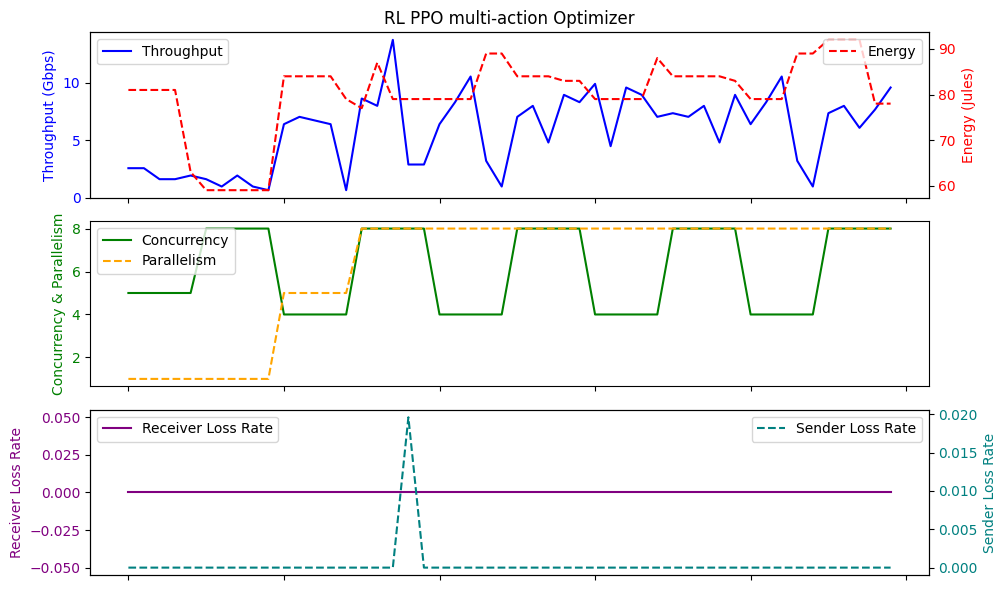

Average Throughput: 5.8112
Total Energy: 4001.0
Total loss rate: 0.01959994630151698
       Throughput  LossRate     Score        RTT     Energy   SenderLR
count   50.000000      50.0  50.00000  50.000000  50.000000  50.000000
mean     5.785600       0.0   5.28000  33.646000  78.860000   0.001011
std      3.584327       0.0   3.22009   2.152285   8.061017   0.004327
min      0.320000       0.0   0.00000  32.500000  60.000000   0.000000
25%      2.320000       0.0   2.00000  32.625000  76.250000   0.000000
50%      6.400000       0.0   6.00000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.00000  33.575000  83.750000   0.000000
max     14.720000       0.0  13.00000  44.300000  92.000000   0.021841
Episode reward: 5.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   10
rewards [1.8, 0.40000000000000013, 3.8, -2.6, 4.799999999999999, 0.0, -2.5999999999999996, 

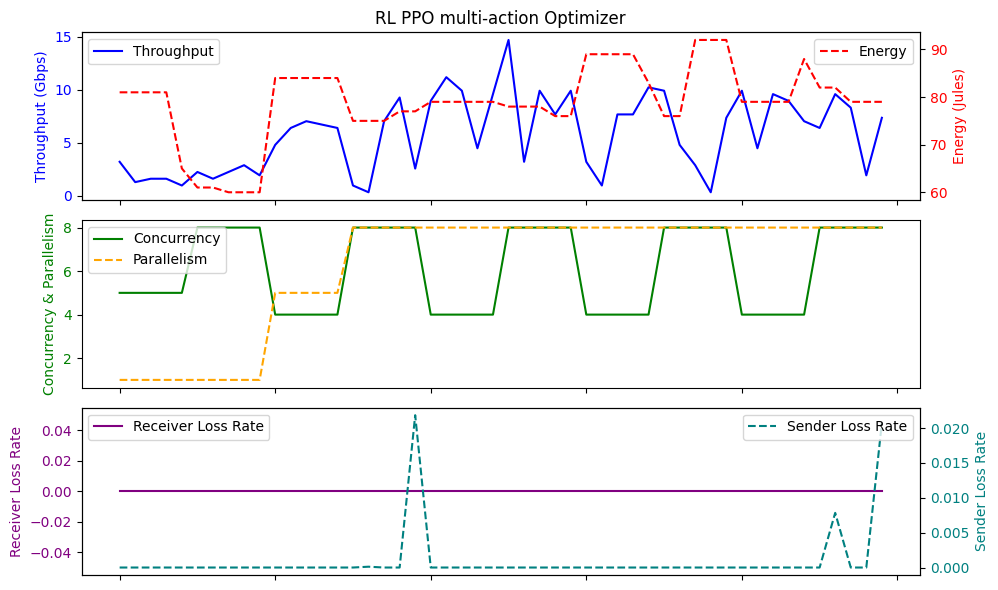

Average Throughput: 5.7856000000000005
Total Energy: 3943.0
Total loss rate: 0.05053551855966104
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.556444       0.0   6.066667  33.924444  78.400000   0.000174
std      2.953898       0.0   2.725302   2.725482   8.233523   0.001169
min      0.960000       0.0   1.000000  32.500000  59.000000   0.000000
25%      4.480000       0.0   4.000000  32.700000  77.000000   0.000000
50%      7.040000       0.0   6.000000  32.900000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.200000  84.000000   0.000000
max     11.200000       0.0  11.000000  46.100000  88.000000   0.007841
Episode reward: 8.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.6, -2.0, 4.4, 1.2000000000000002, 0.20000000000000018, -2.0, 3.199999999999

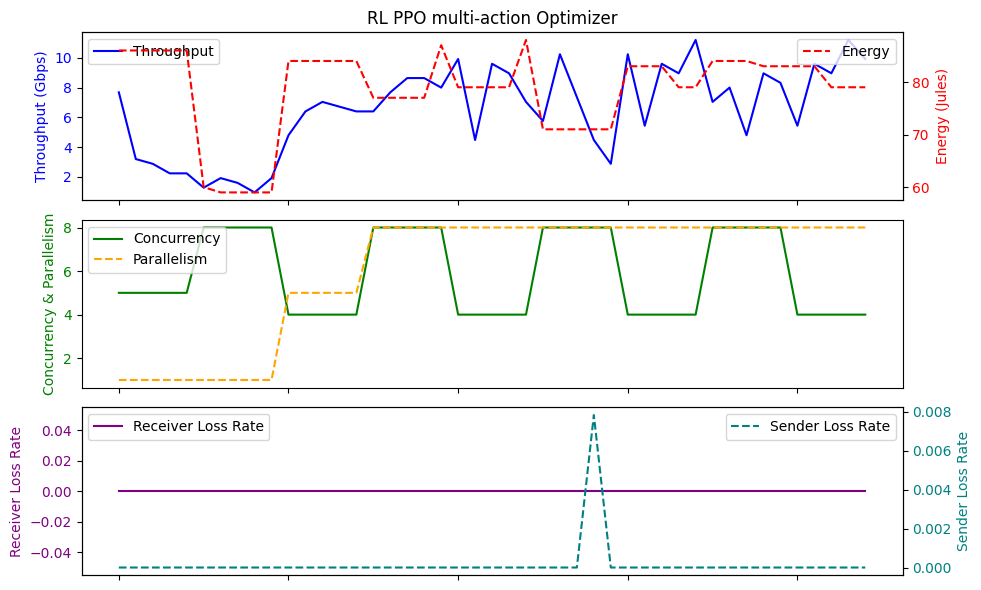

Average Throughput: 6.556444444444445
Total Energy: 3528.0
Total loss rate: 0.007841263375581633
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.080000       0.0   5.577778  33.484444  80.600000       0.0
std      3.299543       0.0   2.980916   2.073639   9.128875       0.0
min      0.320000       0.0   0.000000  32.500000  59.000000       0.0
25%      3.200000       0.0   3.000000  32.700000  79.000000       0.0
50%      6.720000       0.0   6.000000  32.900000  79.000000       0.0
75%      8.640000       0.0   8.000000  33.300000  89.000000       0.0
max     12.480000       0.0  11.000000  44.300000  92.000000       0.0
Episode reward: 5.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.0, -0.7999999999999998, 3.0, 2.5999999999999996, -0.39999999999999947, -0.8000000000

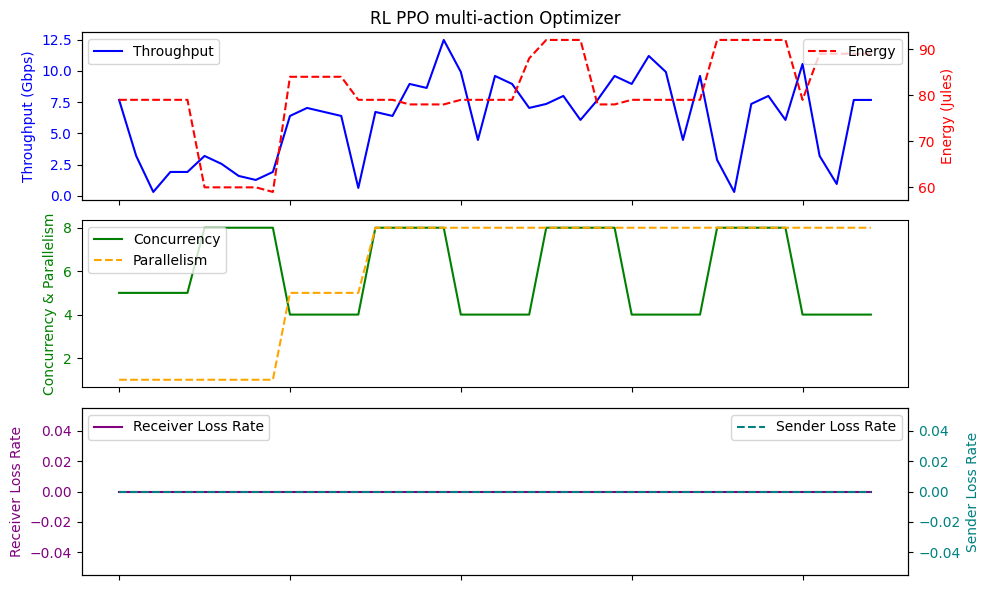

Average Throughput: 6.08
Total Energy: 3627.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.364444       0.0   5.888889  33.513333  77.911111       0.0
std      3.405218       0.0   3.105876   1.565625   8.379689       0.0
min      0.960000       0.0   1.000000  32.500000  59.000000       0.0
25%      3.520000       0.0   3.000000  32.700000  79.000000       0.0
50%      6.720000       0.0   6.000000  32.900000  79.000000       0.0
75%      8.960000       0.0   8.000000  33.500000  84.000000       0.0
max     13.440000       0.0  13.000000  39.300000  89.000000       0.0
Episode reward: 8.8
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.0, -0.3999999999999999, 4.4, 2.0, -2.4000000000000004, 1.8000000000000007, 0.0, -1.2000000000000002, 2.60000000000

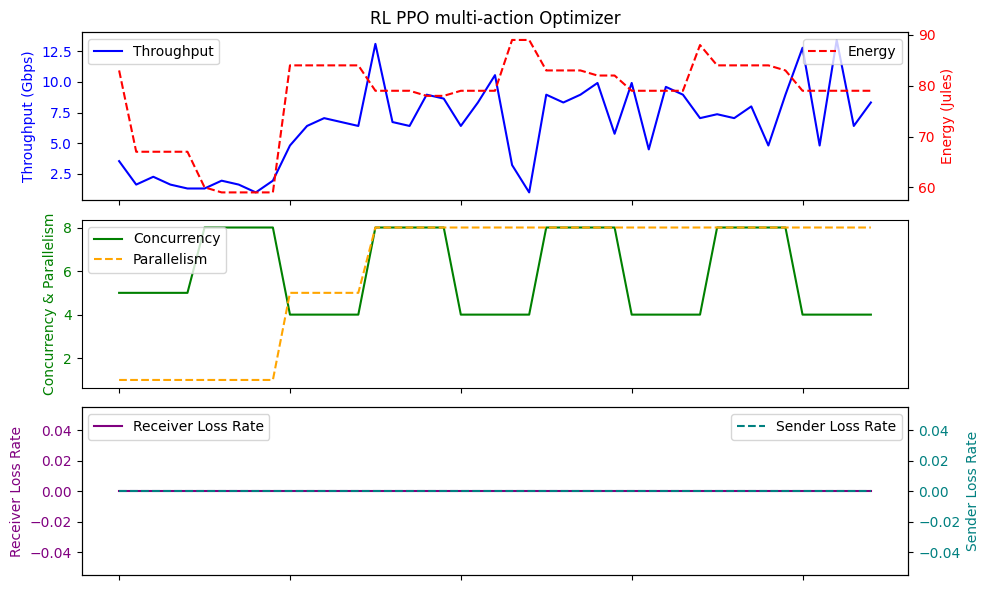

Average Throughput: 6.364444444444444
Total Energy: 3506.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.492444       0.0   5.955556  33.757778  79.488889       0.0
std      3.139517       0.0   2.836095   2.662747   9.116973       0.0
min      0.320000       0.0   0.000000  32.500000  60.000000       0.0
25%      3.200000       0.0   3.000000  32.700000  78.000000       0.0
50%      7.040000       0.0   6.000000  33.000000  83.000000       0.0
75%      8.960000       0.0   8.000000  33.300000  84.000000       0.0
max     12.480000       0.0  11.000000  44.300000  92.000000       0.0
Episode reward: 8.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.6, 1.0, 3.4, 1.7999999999999998, -2.2, 1.0, 1.2000000000000002, -0.5999999999999996, 1.20000000000000

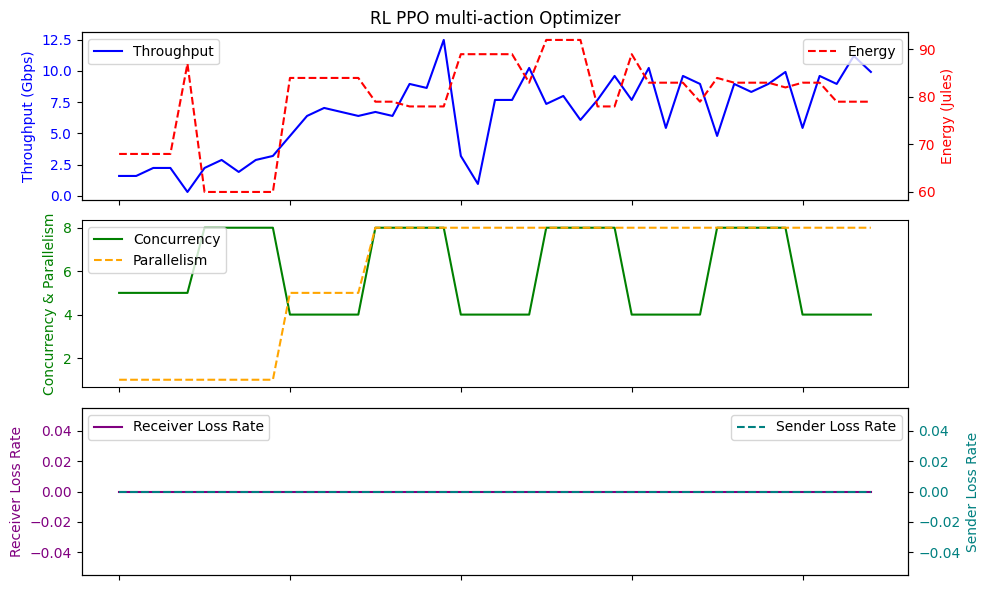

Average Throughput: 6.492444444444445
Total Energy: 3577.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   40.000000      40.0  40.000000  40.000000  40.000000  40.000000
mean     7.040000       0.0   6.475000  33.495000  79.200000   0.000196
std      2.845607       0.0   2.611488   1.869176   8.019847   0.001239
min      0.960000       0.0   1.000000  32.500000  60.000000   0.000000
25%      4.720000       0.0   4.000000  32.600000  79.000000   0.000000
50%      7.040000       0.0   7.000000  32.700000  79.000000   0.000000
75%      9.120000       0.0   8.000000  33.350000  84.000000   0.000000
max     12.480000       0.0  11.000000  40.500000  89.000000   0.007837
Episode reward: 7.0
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   8
rewards [5.2, -2.6, 3.4, 1.7999999999999998, 0.39999999999999947, -1.3999999999999995, 1.3999999999999995, -1.19999999

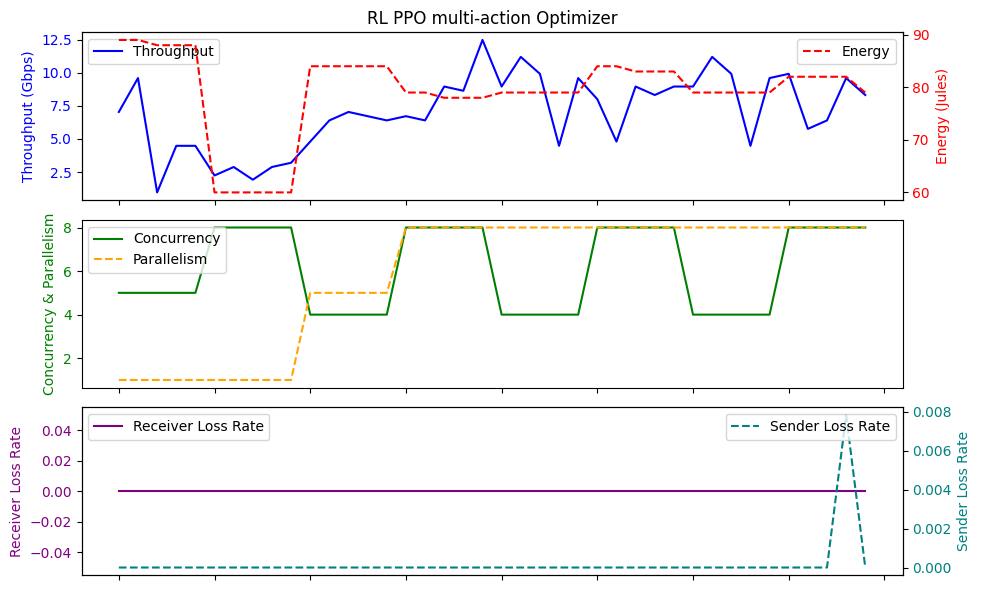

Average Throughput: 7.040000000000001
Total Energy: 3168.0
Total loss rate: 0.00783698156128658
       Throughput  LossRate      Score        RTT    Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.00000  45.000000
mean     6.549333       0.0   6.088889  34.120000  79.60000   0.000610
std      3.355911       0.0   3.073510   3.020129   7.61995   0.003122
min      0.640000       0.0   1.000000  32.500000  59.00000   0.000000
25%      3.200000       0.0   3.000000  32.700000  79.00000   0.000000
50%      6.720000       0.0   6.000000  32.900000  82.00000   0.000000
75%      8.960000       0.0   8.000000  33.300000  84.00000   0.000000
max     13.760000       0.0  13.000000  44.700000  89.00000   0.019600
Episode reward: 8.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [4.4, -2.2, 2.5999999999999996, 1.6000000000000005, 1.3999999999999995, -1.5999999999999

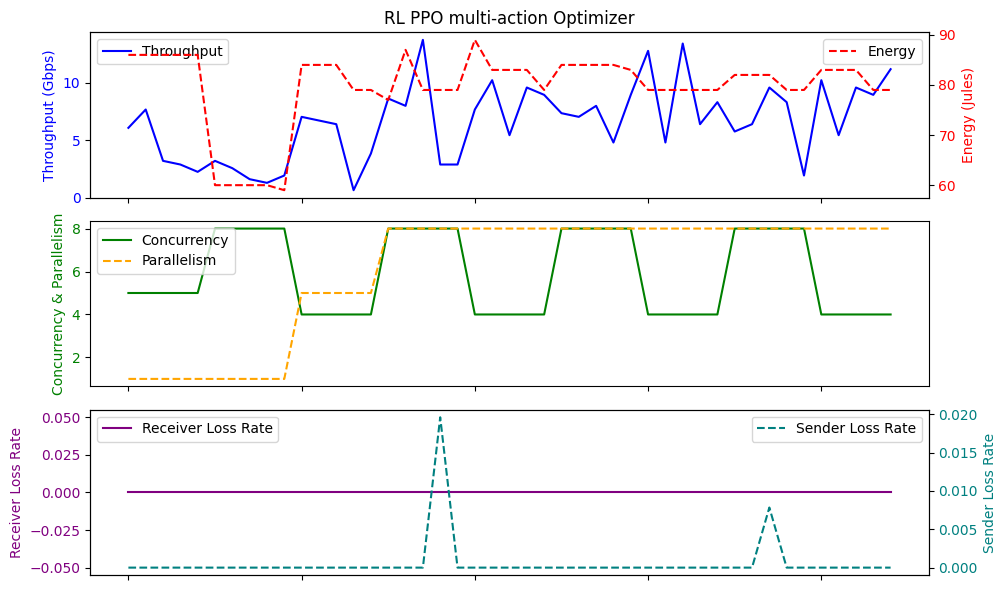

Average Throughput: 6.549333333333332
Total Energy: 3582.0
Total loss rate: 0.02743692786280356
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.030222       0.0   5.600000  33.942222  77.533333   0.000174
std      3.472041       0.0   3.271085   2.884243  10.154712   0.001169
min      0.320000       0.0   0.000000  32.600000  59.000000   0.000000
25%      2.880000       0.0   3.000000  32.600000  71.000000   0.000000
50%      6.400000       0.0   6.000000  32.900000  79.000000   0.000000
75%      8.640000       0.0   8.000000  33.500000  84.000000   0.000000
max     13.440000       0.0  13.000000  46.100000  92.000000   0.007841
Episode reward: 8.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.6, -1.2000000000000002, 4.6, 1.2000000000000002, 0.7999999999999998, -1.7999

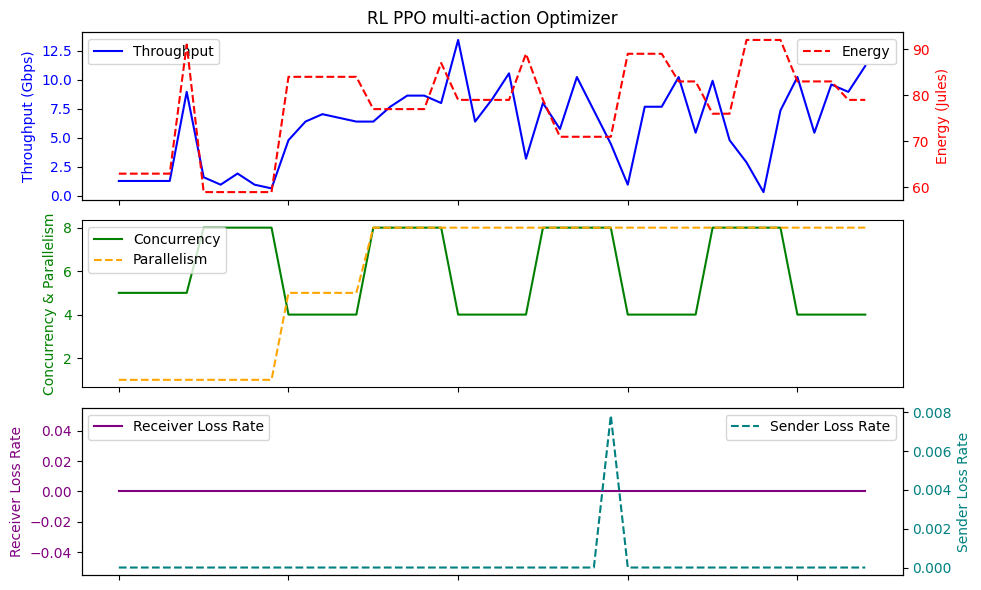

Average Throughput: 6.030222222222222
Total Energy: 3489.0
Total loss rate: 0.007841263375581633
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.193778       0.0   5.688889  33.648889  79.088889   0.000509
std      3.022076       0.0   2.778343   2.318760  10.197643   0.003256
min      0.320000       0.0   0.000000  32.500000  60.000000   0.000000
25%      3.200000       0.0   3.000000  32.700000  77.000000   0.000000
50%      7.040000       0.0   6.000000  33.000000  79.000000   0.000000
75%      8.320000       0.0   8.000000  33.300000  89.000000   0.000000
max     11.200000       0.0  11.000000  44.300000  92.000000   0.021841
Episode reward: 7.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [4.0, -1.4, 2.6, 1.0, 1.9999999999999991, -3.1999999999999993, 0.7999999999999

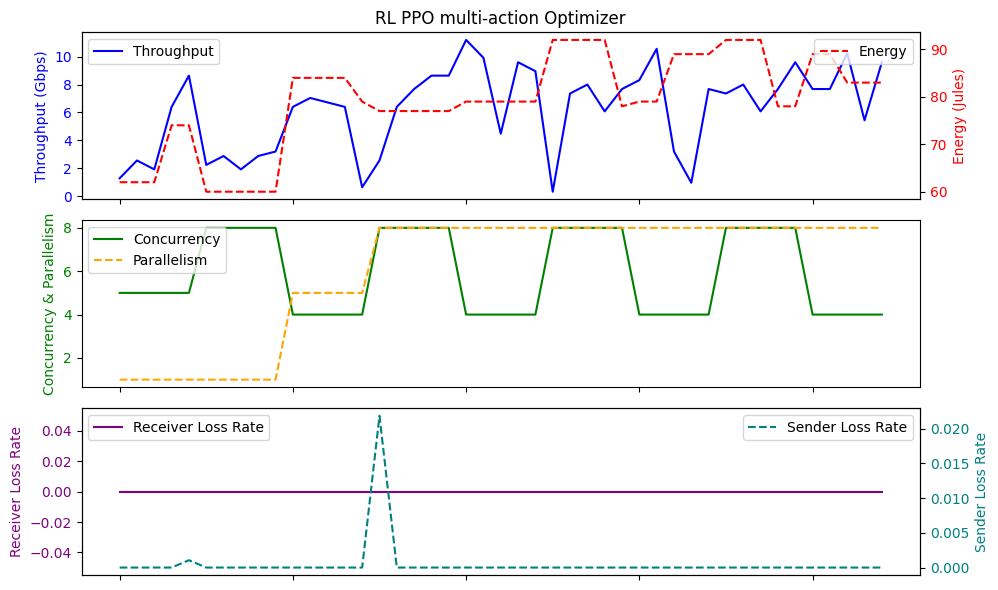

Average Throughput: 6.193777777777778
Total Energy: 3559.0
Total loss rate: 0.022900851405402916
       Throughput  LossRate      Score       RTT  Energy   SenderLR
count   45.000000      45.0  45.000000  45.00000  45.000  45.000000
mean     6.264889       0.0   5.844444  34.14000  74.800   0.000174
std      3.614911       0.0   3.211878   3.07012  11.967   0.001169
min      0.320000       0.0   0.000000  32.60000  50.000   0.000000
25%      2.560000       0.0   3.000000  32.70000  71.000   0.000000
50%      6.720000       0.0   6.000000  32.90000  79.000   0.000000
75%      8.640000       0.0   8.000000  33.30000  79.000   0.000000
max     13.760000       0.0  13.000000  46.10000  92.000   0.007841
Episode reward: 8.2
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.0, 0.20000000000000018, 3.0, 3.2, -1.0, -2.0, 3.4000000000000004, -3.8000000000000007, 3.1999999999999993],  9


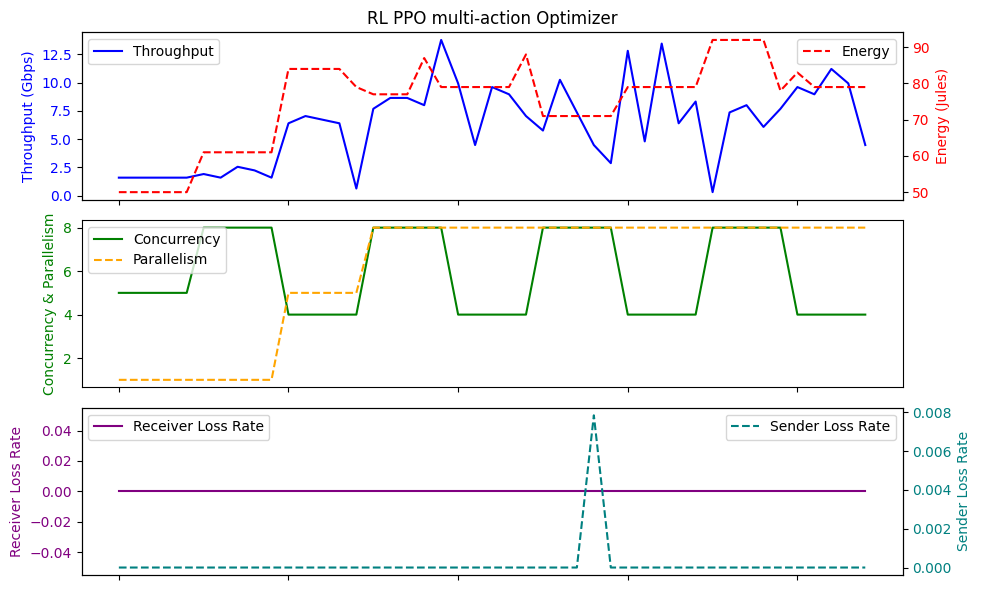

Average Throughput: 6.26488888888889
Total Energy: 3366.0
Total loss rate: 0.007841263375581633
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     5.824000       0.0   5.311111  33.677778  77.444444   0.001297
std      3.589788       0.0   3.363049   2.399705   8.302671   0.004657
min      0.320000       0.0   0.000000  32.500000  60.000000   0.000000
25%      2.560000       0.0   2.000000  32.600000  75.000000   0.000000
50%      6.400000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.300000  83.000000   0.000000
max     11.200000       0.0  11.000000  44.300000  89.000000   0.021841
Episode reward: 8.6
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [0.0, 2.6, 2.1999999999999997, -0.39999999999999947, 1.5999999999999996, -0.400

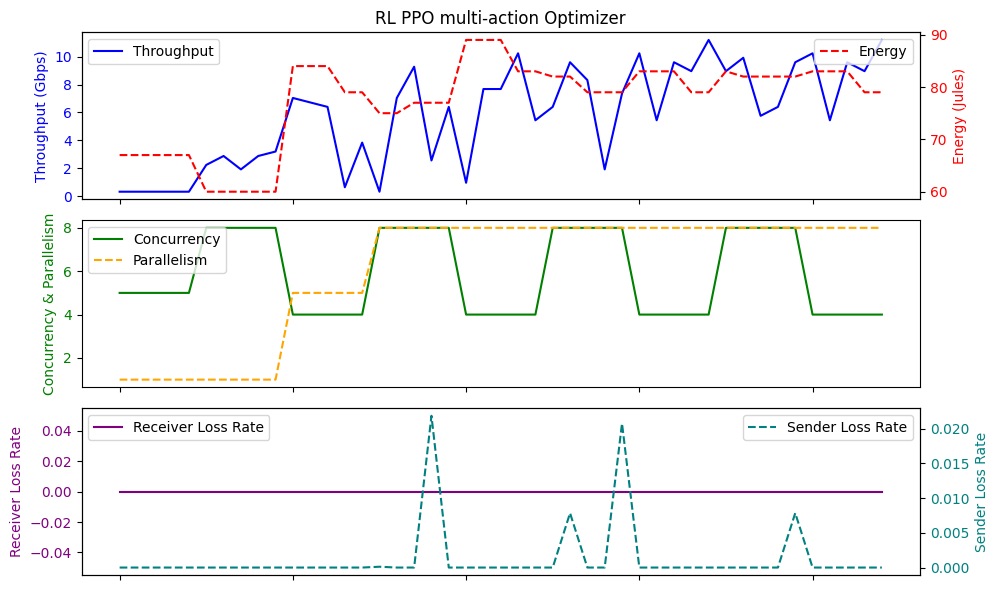

Average Throughput: 5.824
Total Energy: 3485.0
Total loss rate: 0.05837250012094762
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.129778       0.0   5.666667  33.155556  78.200000       0.0
std      3.163395       0.0   2.860388   1.246733  10.001364       0.0
min      0.320000       0.0   0.000000  32.500000  56.000000       0.0
25%      3.840000       0.0   4.000000  32.700000  77.000000       0.0
50%      7.040000       0.0   6.000000  32.800000  79.000000       0.0
75%      8.960000       0.0   8.000000  33.100000  84.000000       0.0
max     11.200000       0.0  11.000000  40.500000  92.000000       0.0
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.0, -1.4, 3.1999999999999997, 2.4000000000000004, 1.3999999999999995, -4.199999999999999, 3.0, -0.

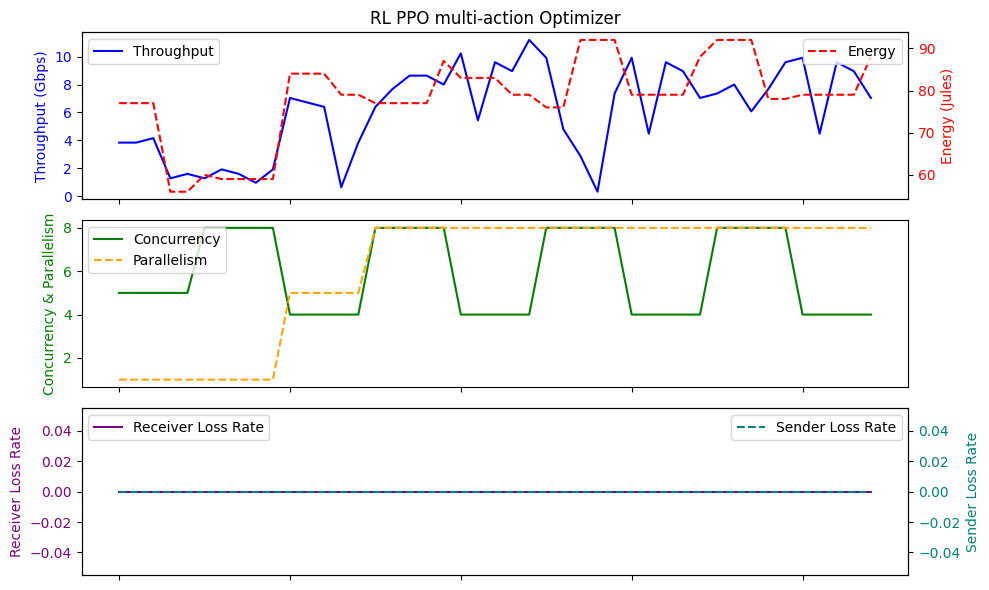

Average Throughput: 6.129777777777777
Total Energy: 3519.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.300444       0.0   5.822222  33.473333  77.933333       0.0
std      3.600935       0.0   3.311748   1.865890   9.163663       0.0
min      0.320000       0.0   0.000000  32.500000  57.000000       0.0
25%      2.880000       0.0   3.000000  32.700000  78.000000       0.0
50%      6.720000       0.0   6.000000  32.800000  79.000000       0.0
75%      8.960000       0.0   8.000000  33.300000  83.000000       0.0
max     13.120000       0.0  12.000000  40.500000  92.000000       0.0
Episode reward: 7.4
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 1.2000000000000002, 3.0, 2.8, 0.1999999999999993, -0.7999999999999989, 1.1999999999999993, -4.1999

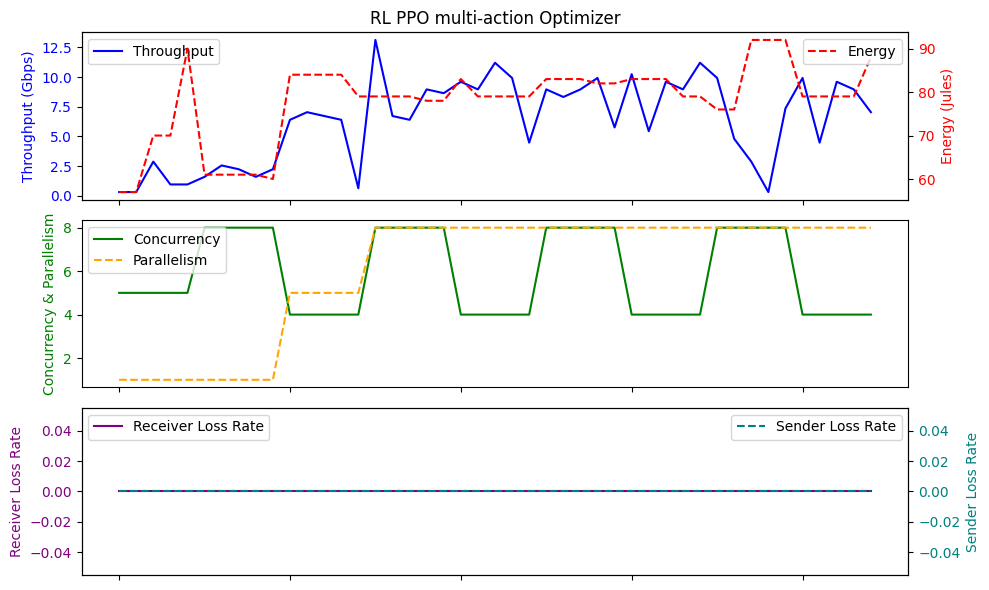

Average Throughput: 6.300444444444444
Total Energy: 3507.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT    Energy   SenderLR
count   40.000000      40.0  40.000000  40.000000  40.00000  40.000000
mean     6.576000       0.0   5.925000  34.467500  76.02500   0.001880
std      3.351452       0.0   3.091655   3.788199   9.95757   0.005062
min      1.600000       0.0   1.000000  32.500000  54.00000   0.000000
25%      2.880000       0.0   2.000000  32.700000  71.00000   0.000000
50%      7.360000       0.0   6.000000  33.000000  79.00000   0.000000
75%      9.600000       0.0   8.250000  33.200000  82.25000   0.000000
max     11.520000       0.0  11.000000  48.800000  90.00000   0.020740
Episode reward: 6.2
actions [array([4, 1]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   8
rewards [4.2, -1.4000000000000004, 2.8, 0.0, 3.0, -2.3999999999999995, 1.9999999999999991, -1.9999999999999991],  8


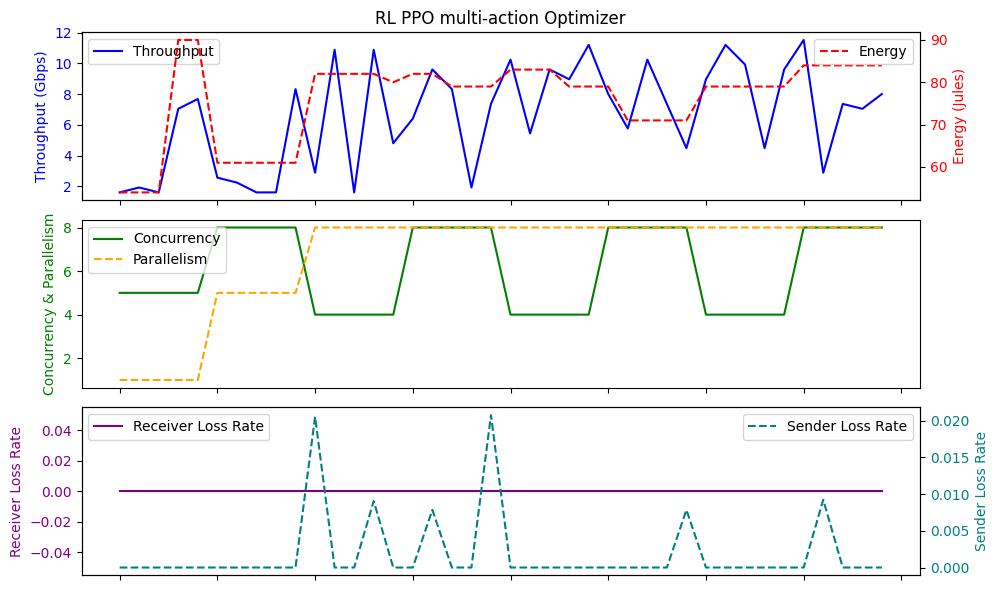

Average Throughput: 6.5760000000000005
Total Energy: 3041.0
Total loss rate: 0.07519532807718451
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.193778       0.0   5.755556  34.000000  78.422222   0.000436
std      3.354909       0.0   3.061161   2.803245  10.044195   0.002922
min      0.320000       0.0   0.000000  32.500000  45.000000   0.000000
25%      3.200000       0.0   3.000000  32.600000  76.000000   0.000000
50%      6.400000       0.0   6.000000  33.000000  82.000000   0.000000
75%      8.320000       0.0   7.000000  33.900000  84.000000   0.000000
max     14.720000       0.0  13.000000  44.300000  89.000000   0.019600
Episode reward: 7.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.2, -0.6000000000000001, 3.4, -0.20000000000000018, 0.0, 2.3999999999999995,

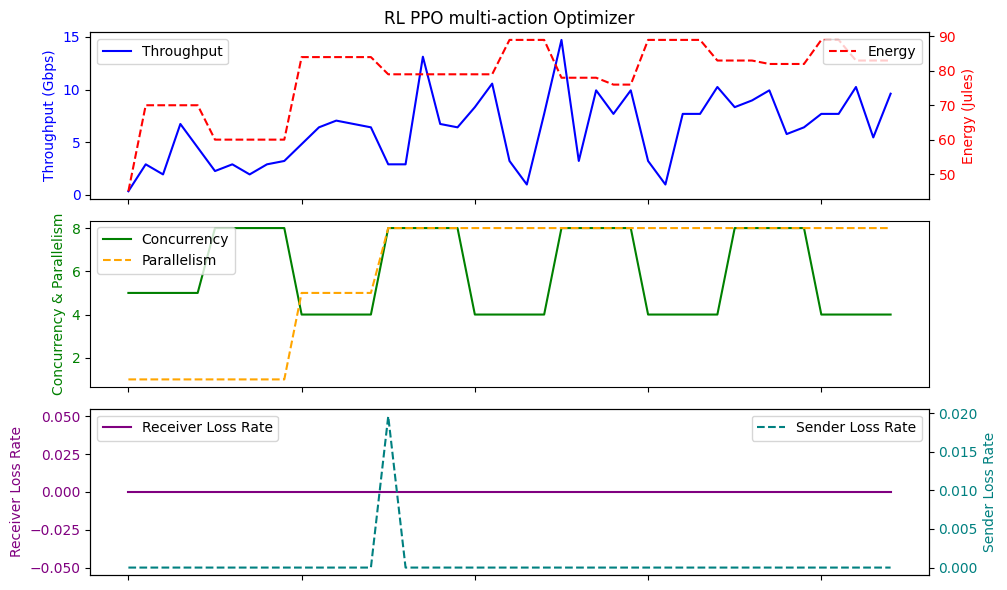

Average Throughput: 6.193777777777778
Total Energy: 3529.0
Total loss rate: 0.01959994630151698
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.151111       0.0   5.688889  33.788889  76.355556   0.000461
std      3.515295       0.0   3.182496   2.671671   9.448799   0.003092
min      0.960000       0.0   1.000000  32.500000  60.000000   0.000000
25%      3.200000       0.0   3.000000  32.600000  76.000000   0.000000
50%      6.720000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.640000       0.0   8.000000  33.600000  83.000000   0.000000
max     13.440000       0.0  13.000000  46.100000  89.000000   0.020740
Episode reward: 7.4
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 1.2000000000000002, 3.8, 1.7999999999999998, -2.2, 0.8000000000000007, 1.

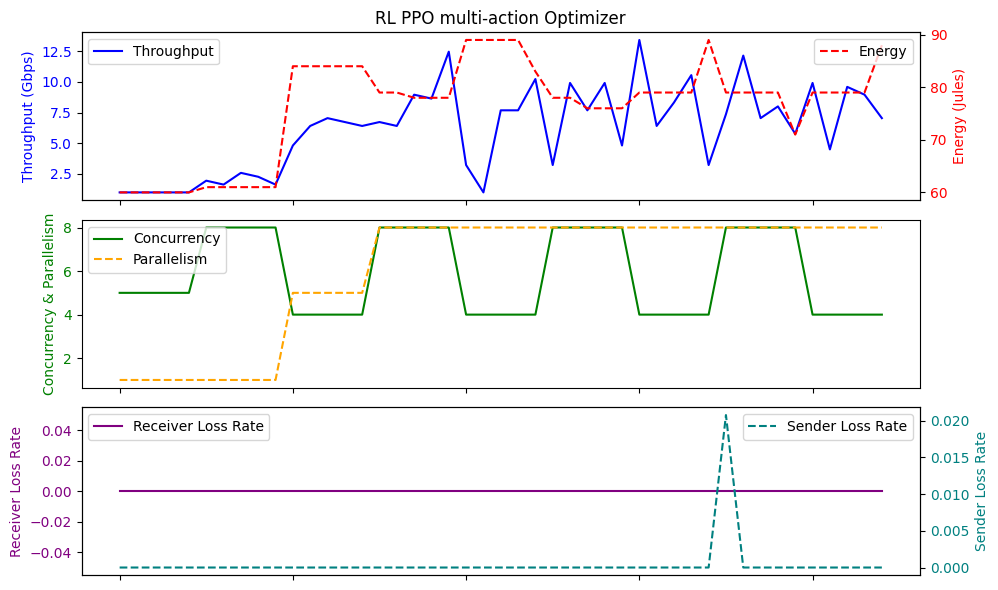

Average Throughput: 6.151111111111112
Total Energy: 3436.0
Total loss rate: 0.020739883981059852
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     5.944889       0.0   5.466667  34.271111  80.044444   0.000809
std      3.285752       0.0   2.912356   3.246580   9.522594   0.003449
min      0.960000       0.0   1.000000  32.500000  60.000000   0.000000
25%      2.880000       0.0   3.000000  32.600000  79.000000   0.000000
50%      6.400000       0.0   6.000000  32.800000  82.000000   0.000000
75%      7.680000       0.0   7.000000  33.900000  89.000000   0.000000
max     13.120000       0.0  12.000000  44.300000  90.000000   0.020740
Episode reward: 5.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.8, -0.3999999999999999, 3.6, 1.0, -1.4000000000000004, 1.6000000000000005, 

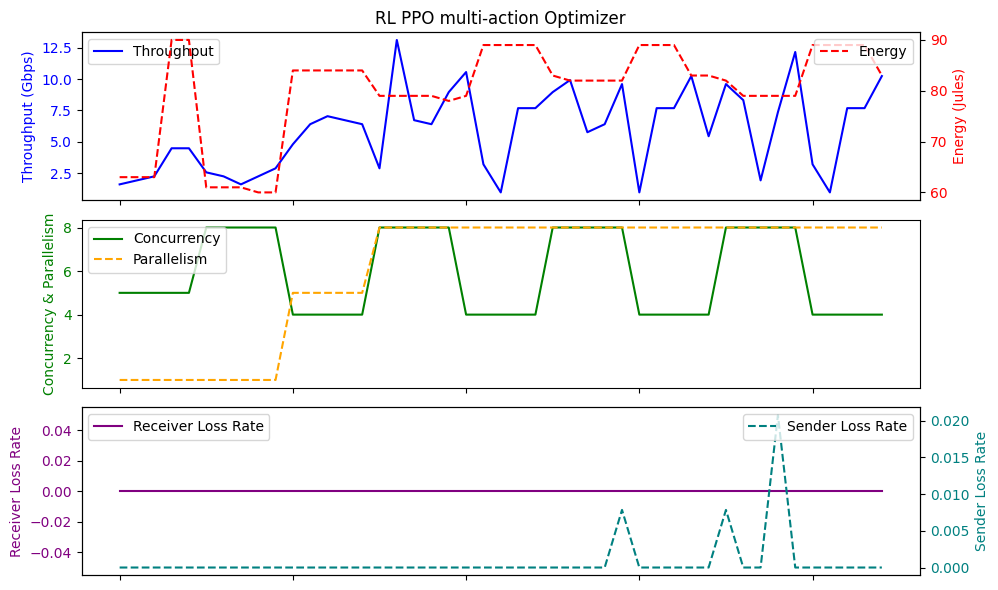

Average Throughput: 5.9448888888888884
Total Energy: 3602.0
Total loss rate: 0.03641384710363301
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.492444       0.0   5.955556  34.420000  75.977778   0.000896
std      4.003560       0.0   3.710890   3.330957   9.509538   0.004205
min      0.320000       0.0   0.000000  32.500000  50.000000   0.000000
25%      2.880000       0.0   3.000000  32.600000  76.000000   0.000000
50%      6.720000       0.0   6.000000  33.000000  79.000000   0.000000
75%      9.600000       0.0   9.000000  34.000000  79.000000   0.000000
max     13.760000       0.0  13.000000  46.100000  92.000000   0.020740
Episode reward: 8.4
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [0.4, 1.8000000000000003, 3.0, 2.0, 0.9999999999999991, -1.799999999999999, 2.

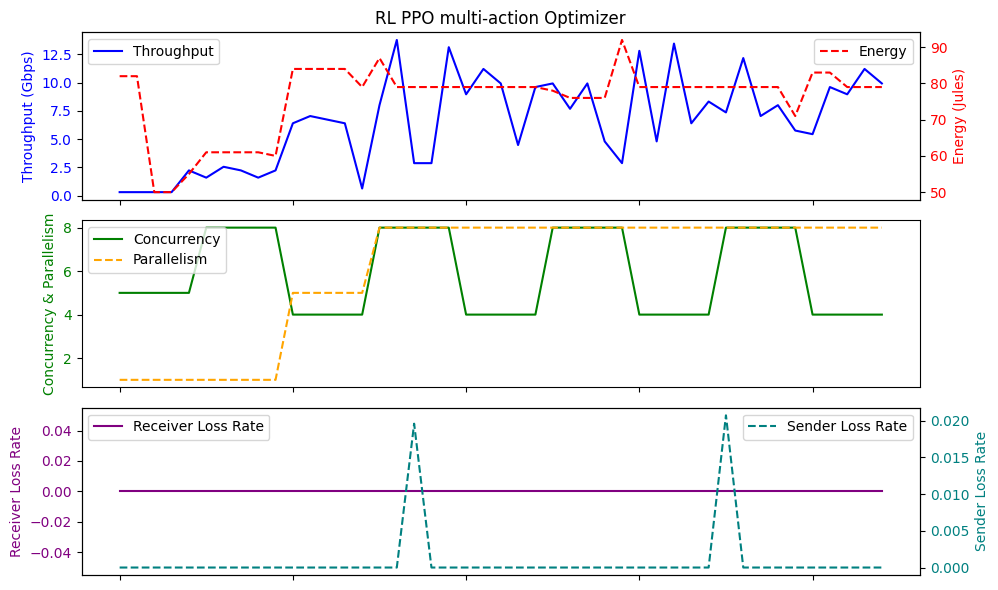

Average Throughput: 6.492444444444445
Total Energy: 3419.0
Total loss rate: 0.04033983028257683
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.037333       0.0   5.533333  33.911111  77.822222   0.000436
std      3.595618       0.0   3.237564   2.644911  11.068565   0.002922
min      0.320000       0.0   0.000000  32.500000  58.000000   0.000000
25%      2.880000       0.0   3.000000  32.700000  78.000000   0.000000
50%      6.720000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.300000  84.000000   0.000000
max     13.760000       0.0  12.000000  44.700000  92.000000   0.019600
Episode reward: 8.2
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [0.6, 1.6, 3.8, 0.40000000000000036, 1.799999999999999, -1.5999999999999996, 0.

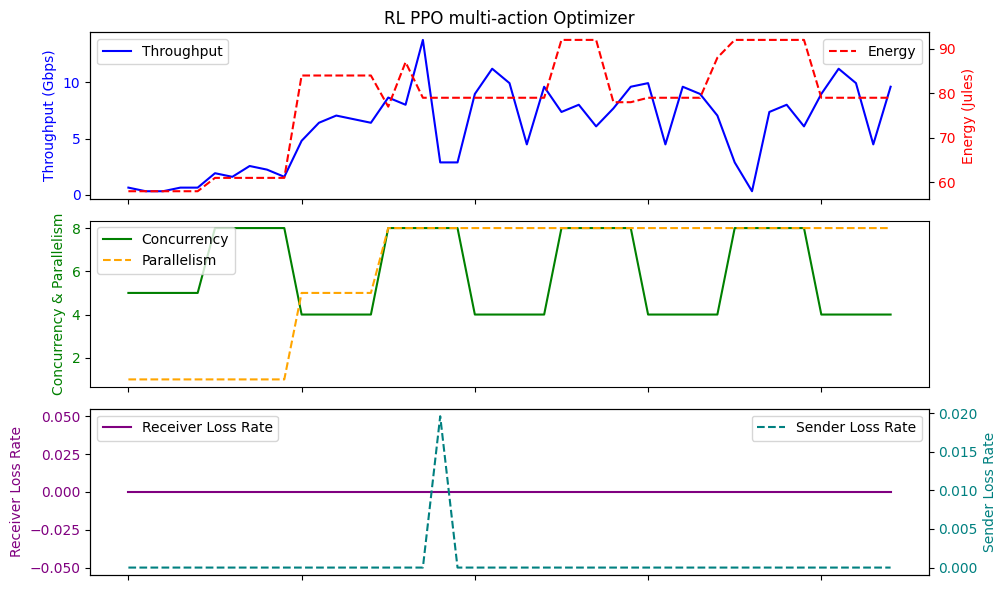

Average Throughput: 6.0373333333333346
Total Energy: 3502.0
Total loss rate: 0.01959994630151698
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.044444       0.0   5.533333  33.773333  76.933333   0.000112
std      3.516178       0.0   3.293244   3.070416   9.700984   0.000754
min      0.320000       0.0   0.000000  32.500000  57.000000   0.000000
25%      2.560000       0.0   2.000000  32.600000  73.000000   0.000000
50%      7.040000       0.0   7.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.200000  83.000000   0.000000
max     12.160000       0.0  11.000000  46.100000  89.000000   0.005060
Episode reward: 6.0
actions [array([4, 1]), array([1, 4]), array([2, 1]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [6.2, -4.0, 3.2, -5.4, 7.4, -0.20000000000000018, 0.5999999999999996, -0.20000

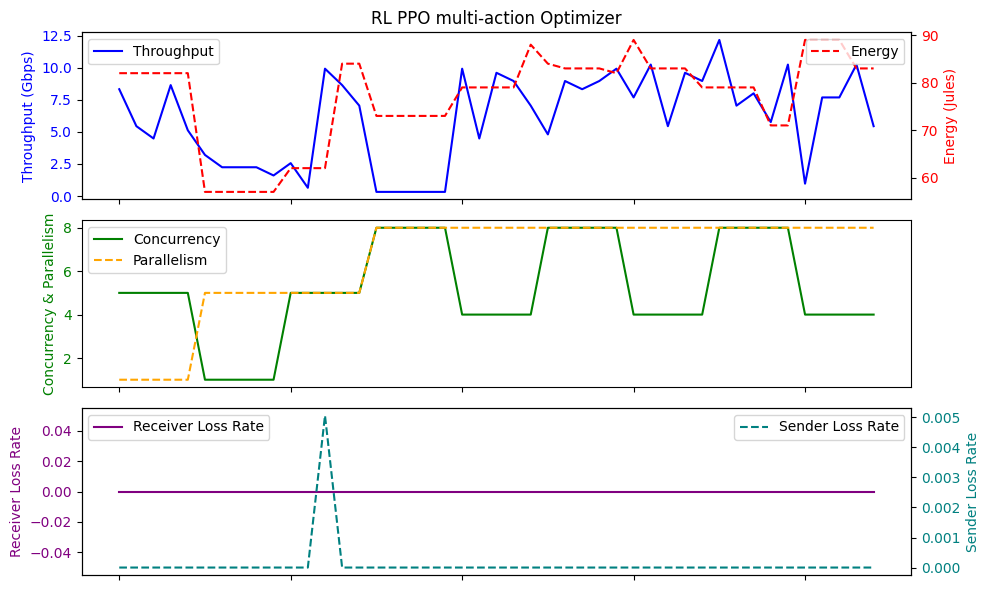

Average Throughput: 6.044444444444444
Total Energy: 3462.0
Total loss rate: 0.005060183244505659
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.584889       0.0   6.088889  34.451111  76.444444   0.000666
std      3.359300       0.0   2.975829   3.888305  10.415364   0.003355
min      0.960000       0.0   1.000000  32.500000  57.000000   0.000000
25%      3.200000       0.0   3.000000  32.700000  77.000000   0.000000
50%      7.040000       0.0   6.000000  33.000000  79.000000   0.000000
75%      8.320000       0.0   8.000000  33.600000  84.000000   0.000000
max     13.760000       0.0  13.000000  48.800000  89.000000   0.020740
Episode reward: 8.8
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.0, -0.7999999999999998, 3.8, 2.4000000000000004, -1.0, -1.2000000000000002,

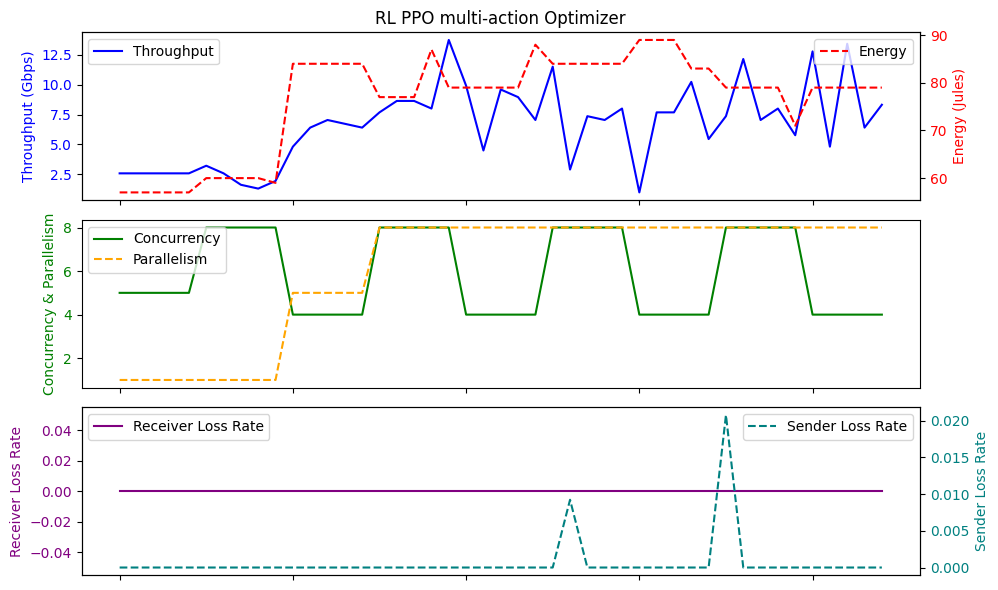

Average Throughput: 6.584888888888889
Total Energy: 3440.0
Total loss rate: 0.029958472533511835
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.222222       0.0   5.755556  34.275556  79.222222   0.000784
std      3.679403       0.0   3.317691   3.226323   8.067581   0.003301
min      0.960000       0.0   1.000000  32.500000  59.000000   0.000000
25%      2.880000       0.0   2.000000  32.600000  79.000000   0.000000
50%      6.400000       0.0   6.000000  32.800000  81.000000   0.000000
75%      9.600000       0.0   8.000000  33.600000  83.000000   0.000000
max     13.760000       0.0  12.000000  44.700000  89.000000   0.019600
Episode reward: 5.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.8, -0.19999999999999996, 4.4, 1.2000000000000002, 1.3999999999999995, -3.0,

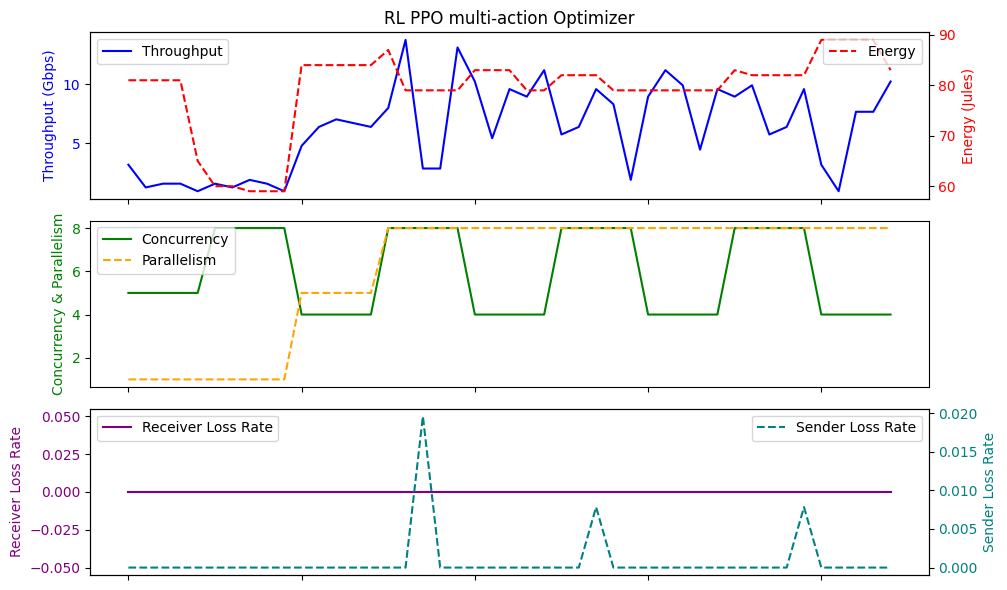

Average Throughput: 6.222222222222222
Total Energy: 3565.0
Total loss rate: 0.035273909424090144
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   40.000000      40.0  40.000000  40.000000  40.000000  40.000000
mean     6.400000       0.0   6.000000  33.805000  74.950000   0.000196
std      3.879455       0.0   3.441824   1.799993   7.598752   0.001240
min      0.320000       0.0   0.000000  32.500000  51.000000   0.000000
25%      3.120000       0.0   3.000000  32.700000  73.250000   0.000000
50%      6.560000       0.0   6.000000  33.200000  78.000000   0.000000
75%      8.720000       0.0   8.000000  34.000000  79.000000   0.000000
max     14.720000       0.0  13.000000  39.100000  88.000000   0.007841
Episode reward: 5.8
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   8
rewards [4.0, -1.7999999999999998, 2.8, 2.8, -0.39999999999999947, -0.40000000000000036, 1.8000000000

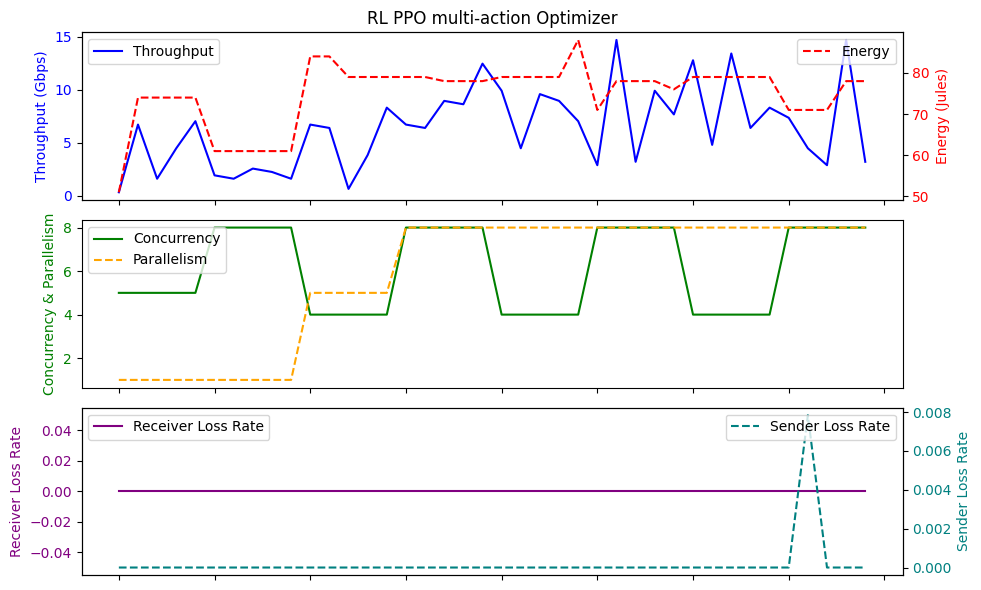

Average Throughput: 6.4
Total Energy: 2998.0
Total loss rate: 0.007841263375581633
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.037333       0.0   5.600000  33.593333  76.866667   0.000662
std      3.899300       0.0   3.601767   1.561526   8.435854   0.003434
min      0.320000       0.0   0.000000  32.600000  59.000000   0.000000
25%      2.880000       0.0   3.000000  32.700000  71.000000   0.000000
50%      6.400000       0.0   6.000000  33.100000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.700000  79.000000   0.000000
max     14.720000       0.0  13.000000  40.500000  92.000000   0.021841
Episode reward: 8.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.0, -0.6000000000000001, 3.6, -0.5999999999999996, 3.5999999999999996, -1.5999999999999996

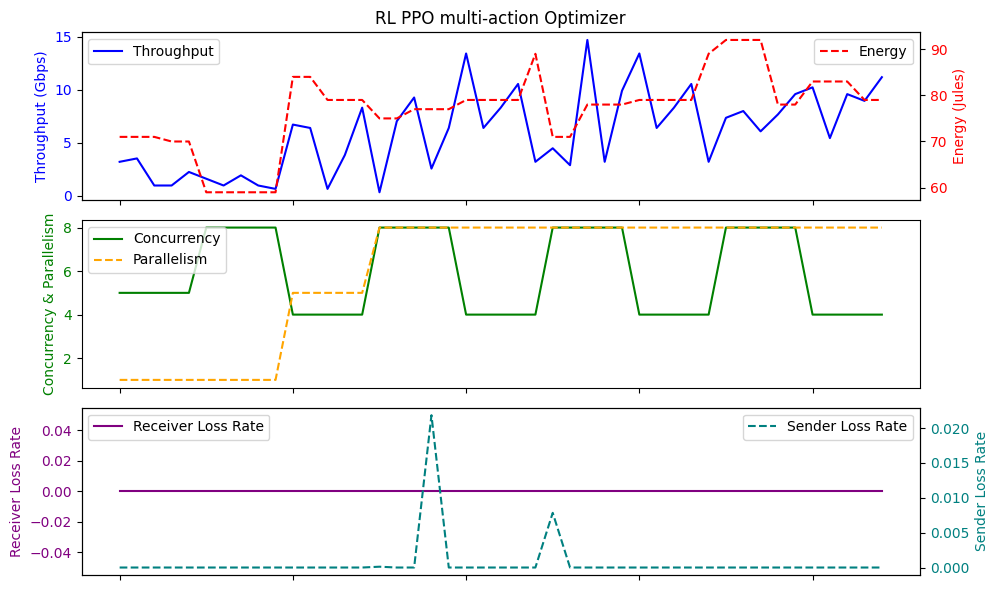

Average Throughput: 6.037333333333334
Total Energy: 3459.0
Total loss rate: 0.029799916392896243
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     5.895111       0.0   5.444444  33.493333  77.533333   0.000485
std      3.206894       0.0   2.832888   2.407224  10.924535   0.003256
min      0.640000       0.0   1.000000  32.500000  57.000000   0.000000
25%      2.560000       0.0   2.000000  32.600000  77.000000   0.000000
50%      6.720000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.640000       0.0   8.000000  33.200000  84.000000   0.000000
max     10.240000       0.0  10.000000  44.300000  92.000000   0.021841
Episode reward: 5.6
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.4, 0.8000000000000003, 2.5999999999999996, 1.4000000000000004, 1.2000000000

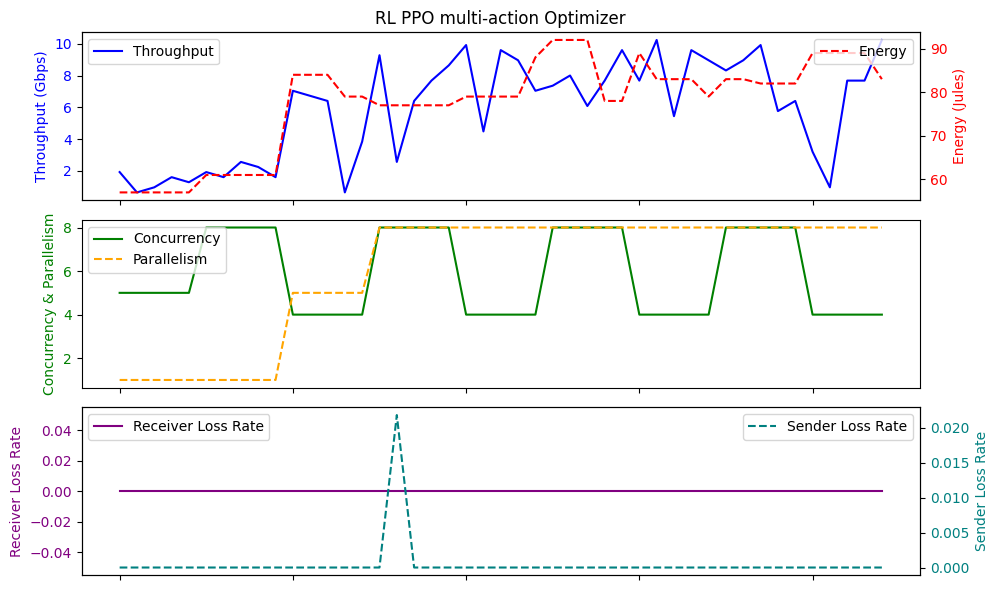

Average Throughput: 5.895111111111111
Total Energy: 3489.0
Total loss rate: 0.021841160771802814
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.122667       0.0   5.622222  33.577778  77.533333   0.000488
std      3.655953       0.0   3.386396   1.657063   7.263232   0.003256
min      0.320000       0.0   0.000000  32.500000  60.000000   0.000000
25%      2.880000       0.0   3.000000  32.700000  76.000000   0.000000
50%      6.400000       0.0   6.000000  33.000000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.600000  83.000000   0.000000
max     14.720000       0.0  13.000000  40.500000  89.000000   0.021841
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 1.6, 3.4, -2.6, 5.0, -1.4000000000000004, 1.0, -1.2000000000000002, 0.60

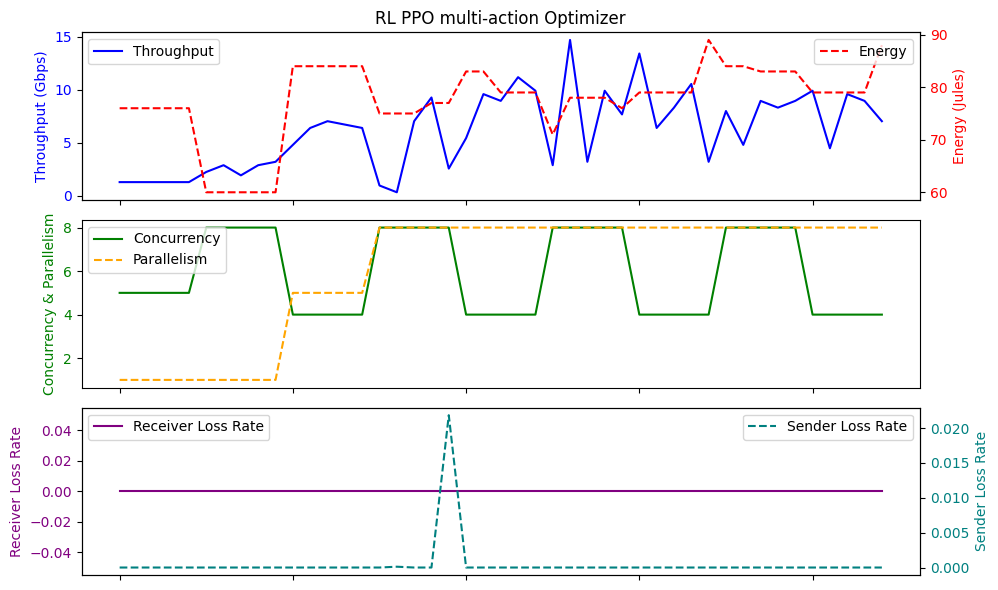

Average Throughput: 6.1226666666666665
Total Energy: 3489.0
Total loss rate: 0.02195865301731461
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.129778       0.0   5.622222  33.940000  80.066667   0.001245
std      3.348521       0.0   2.925506   2.941351   7.799767   0.004440
min      0.640000       0.0   1.000000  32.500000  61.000000   0.000000
25%      2.880000       0.0   3.000000  32.600000  79.000000   0.000000
50%      6.400000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.300000  84.000000   0.000000
max     13.760000       0.0  12.000000  44.700000  89.000000   0.020740
Episode reward: 5.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.0, -0.7999999999999998, 3.0, 1.2000000000000002, 1.799999999999999, -1.1999

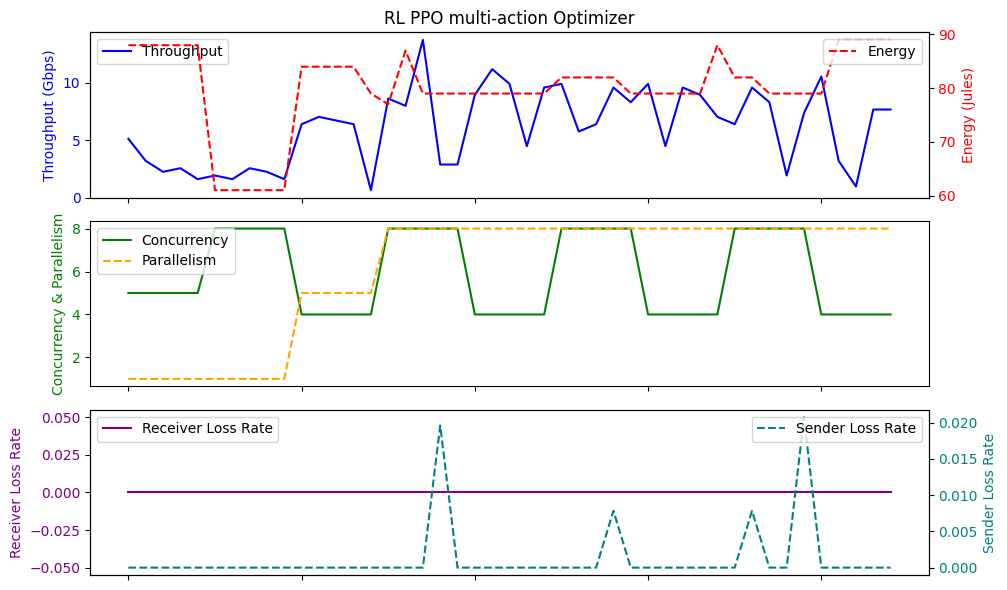

Average Throughput: 6.129777777777777
Total Energy: 3603.0
Total loss rate: 0.05601379340514999
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.00000
mean     6.264889       0.0   5.800000  33.762222  78.022222   0.00064
std      3.609757       0.0   3.375042   2.096132   6.942913   0.00320
min      0.640000       0.0   1.000000  32.500000  60.000000   0.00000
25%      2.880000       0.0   2.000000  32.600000  79.000000   0.00000
50%      6.400000       0.0   6.000000  33.000000  79.000000   0.00000
75%      8.960000       0.0   8.000000  33.500000  83.000000   0.00000
max     13.440000       0.0  13.000000  40.800000  89.000000   0.01960
Episode reward: 8.2
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.0, 0.20000000000000018, 2.5999999999999996, 1.0, 3.000000000000001, -3.80000000000000

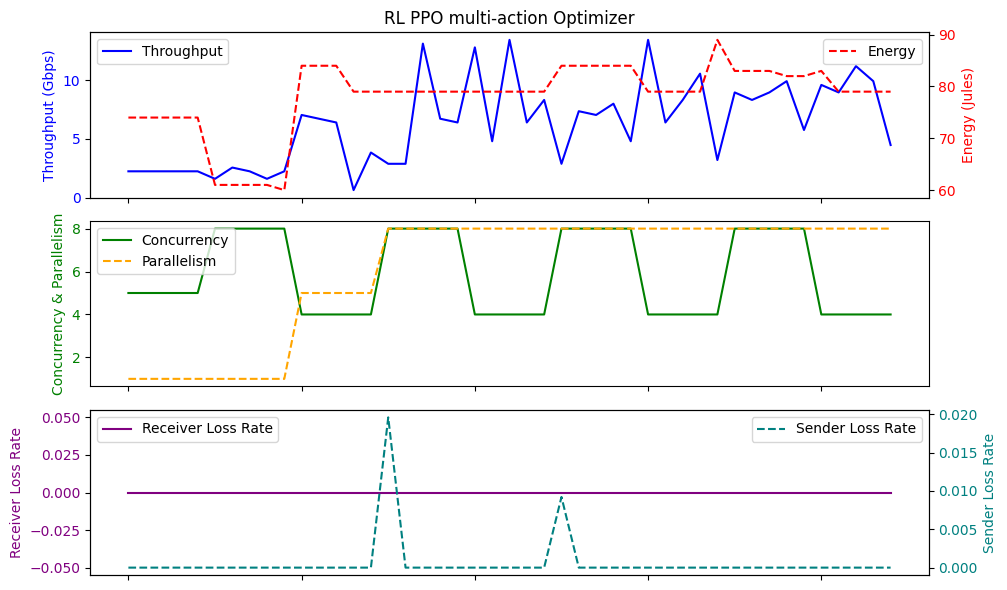

Average Throughput: 6.26488888888889
Total Energy: 3511.0
Total loss rate: 0.028818534853968965
       Throughput  LossRate     Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.00000  45.000000  45.000000      45.0
mean     6.492444       0.0   6.00000  33.731111  80.377778       0.0
std      3.609199       0.0   3.39786   2.654569   8.661012       0.0
min      0.320000       0.0   0.00000  32.500000  59.000000       0.0
25%      3.840000       0.0   4.00000  32.800000  79.000000       0.0
50%      7.680000       0.0   7.00000  33.000000  83.000000       0.0
75%      8.640000       0.0   8.00000  33.200000  84.000000       0.0
max     13.760000       0.0  13.00000  44.700000  92.000000       0.0
Episode reward: 8.0
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.4, -1.7999999999999998, 3.1999999999999997, 3.6000000000000005, -0.6000000000000005, -1.399999

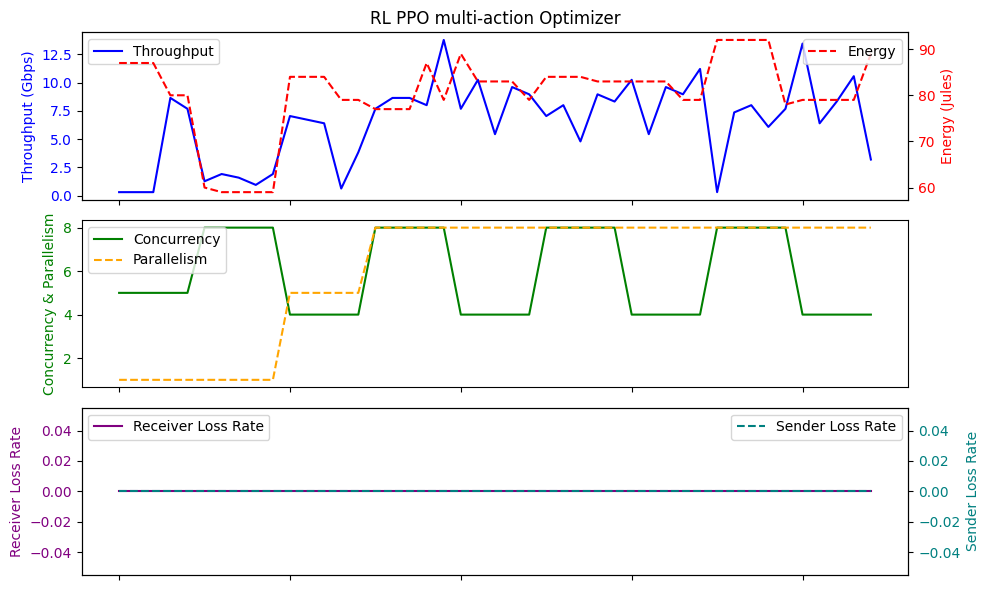

Average Throughput: 6.492444444444444
Total Energy: 3617.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.151111       0.0   5.733333  33.666667  77.555556   0.000436
std      3.549555       0.0   3.243175   2.406431   8.035590   0.002922
min      0.320000       0.0   0.000000  32.500000  60.000000   0.000000
25%      2.880000       0.0   3.000000  32.600000  76.000000   0.000000
50%      6.400000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.400000  79.000000   0.000000
max     13.760000       0.0  13.000000  44.700000  92.000000   0.019600
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.0, -0.6000000000000001, 2.6, 1.4000000000000004, 1.5999999999999996, -3.4000000000000004, 3.

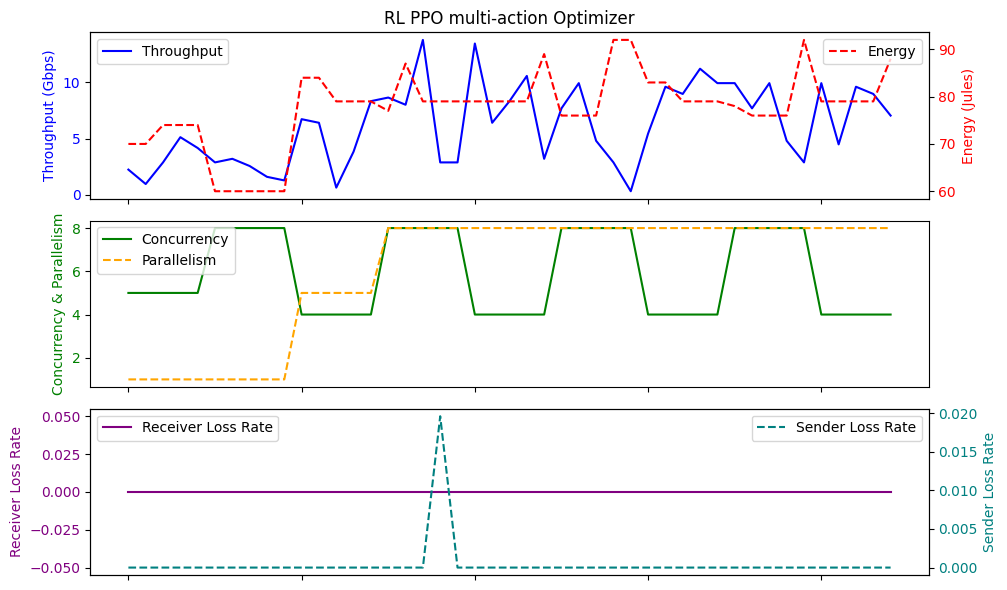

Average Throughput: 6.151111111111112
Total Energy: 3490.0
Total loss rate: 0.01959994630151698
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.677333       0.0   6.177778  34.446667  76.244444   0.000205
std      3.521058       0.0   3.228347   3.792493  10.563995   0.001374
min      0.960000       0.0   1.000000  32.500000  56.000000   0.000000
25%      4.800000       0.0   5.000000  32.700000  71.000000   0.000000
50%      7.040000       0.0   6.000000  33.100000  79.000000   0.000000
75%      9.600000       0.0   9.000000  33.500000  84.000000   0.000000
max     13.120000       0.0  12.000000  48.800000  89.000000   0.009219
Episode reward: 8.6
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 1.0, 4.0, 2.0, 0.5999999999999996, -2.3999999999999995, 1.399999999999999

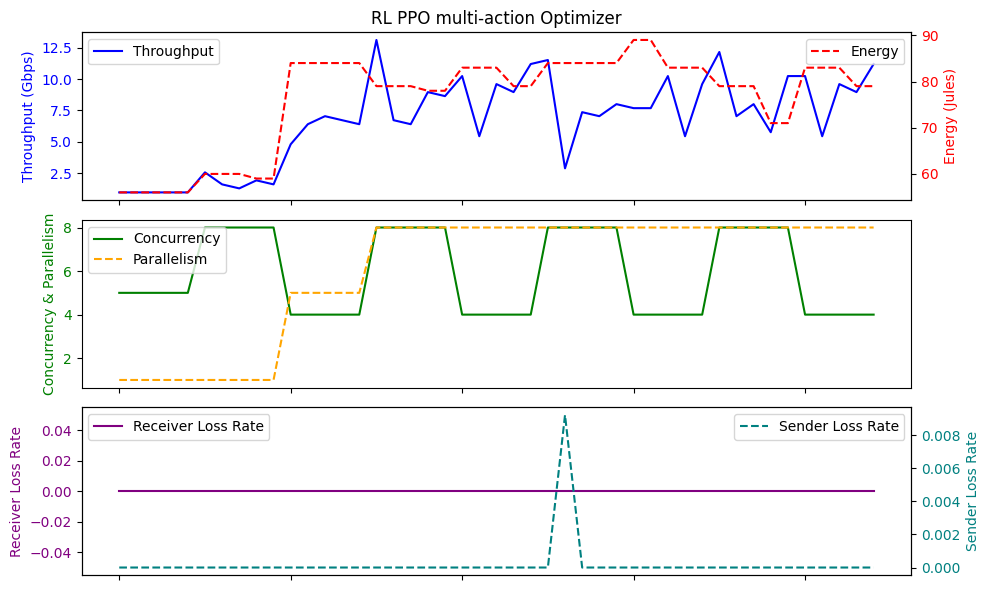

Average Throughput: 6.6773333333333325
Total Energy: 3431.0
Total loss rate: 0.009218588552451983
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count    40.00000      40.0  40.000000  40.000000  40.000000      40.0
mean      6.54400       0.0   6.100000  33.747500  79.625000       0.0
std       3.11008       0.0   2.790092   2.947053   8.511493       0.0
min       0.64000       0.0   1.000000  32.500000  60.000000       0.0
25%       5.04000       0.0   4.750000  32.675000  77.000000       0.0
50%       7.04000       0.0   6.500000  32.800000  82.500000       0.0
75%       8.72000       0.0   8.000000  33.225000  84.750000       0.0
max      12.16000       0.0  11.000000  46.100000  89.000000       0.0
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   8
rewards [5.4, -3.2, 2.5999999999999996, 2.4000000000000004, -1.6000000000000005, 2.0, 1.0, -1.199999999999999

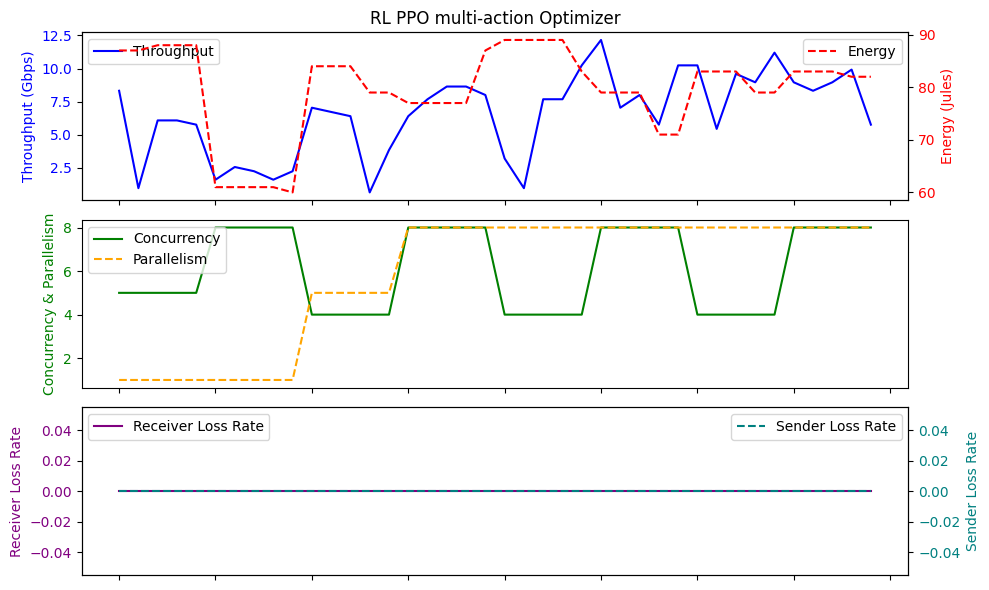

Average Throughput: 6.544000000000001
Total Energy: 3185.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     5.980444       0.0   5.444444  33.448889  79.000000   0.000488
std      3.409725       0.0   3.108314   2.055660   8.934102   0.003256
min      0.320000       0.0   0.000000  32.500000  58.000000   0.000000
25%      2.560000       0.0   2.000000  32.700000  76.000000   0.000000
50%      7.040000       0.0   6.000000  33.000000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.200000  83.000000   0.000000
max     11.200000       0.0  11.000000  44.300000  92.000000   0.021841
Episode reward: 8.600000000000001
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.6, -1.4000000000000001, 3.5999999999999996, -1.4, 4.4, -1.2000000000000002, 0.

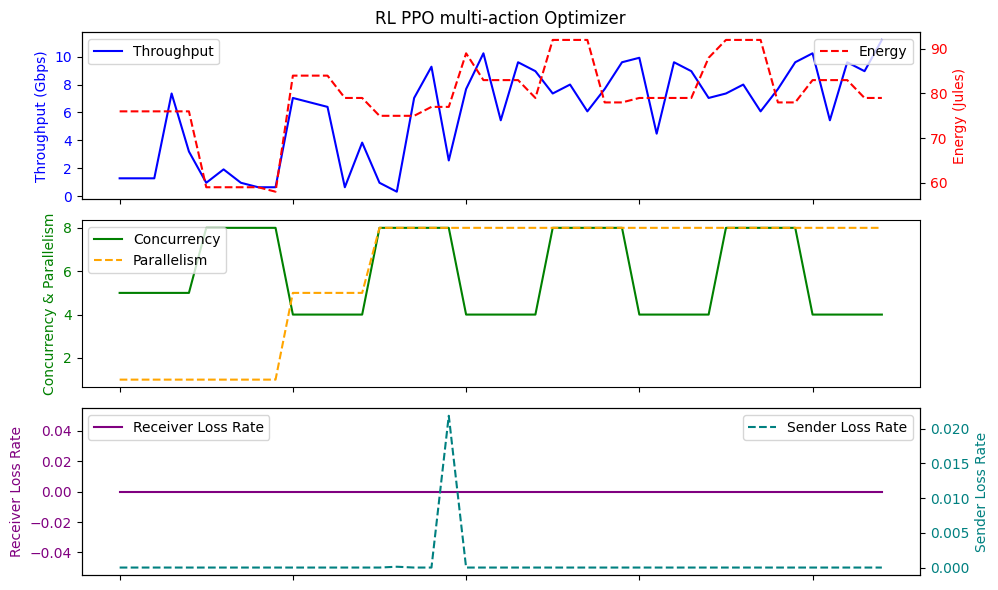

Average Throughput: 5.980444444444444
Total Energy: 3555.0
Total loss rate: 0.02195865301731461
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.357333       0.0   5.888889  34.071111  75.977778   0.000349
std      3.343405       0.0   2.948206   2.970126   8.158902   0.001634
min      0.640000       0.0   1.000000  32.500000  59.000000   0.000000
25%      3.200000       0.0   3.000000  32.700000  71.000000   0.000000
50%      7.040000       0.0   6.000000  32.900000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.500000  81.000000   0.000000
max     14.720000       0.0  13.000000  46.100000  89.000000   0.007841
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.2, 0.0, 2.8, 2.2, 0.39999999999999947, -1.3999999999999995, 1.99999999999999

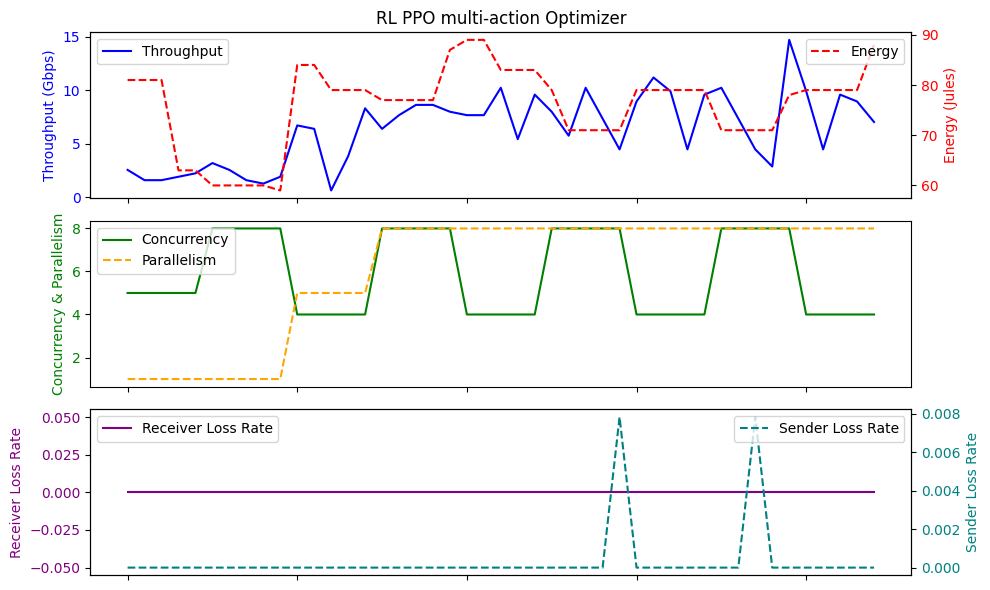

Average Throughput: 6.357333333333334
Total Energy: 3419.0
Total loss rate: 0.015682526751163266
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.129778       0.0   5.622222  33.628889  78.244444   0.001473
std      3.631911       0.0   3.399792   2.284396   7.891755   0.007498
min      0.960000       0.0   1.000000  32.500000  62.000000   0.000000
25%      2.880000       0.0   2.000000  32.700000  74.000000   0.000000
50%      7.040000       0.0   6.000000  32.900000  79.000000   0.000000
75%      8.320000       0.0   8.000000  33.200000  84.000000   0.000000
max     15.680000       0.0  14.000000  44.300000  89.000000   0.049245
Episode reward: 8.6
actions [array([4, 1]), array([1, 4]), array([2, 1]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [8.0, -5.8, -0.20000000000000018, 3.5999999999999996, 0.20000000000000018, -0.

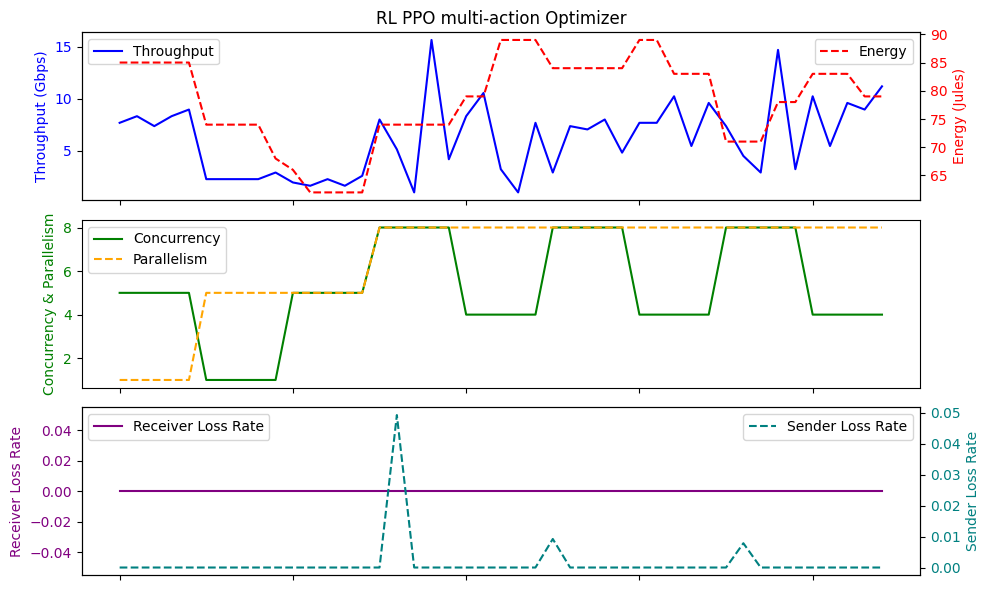

Average Throughput: 6.129777777777777
Total Energy: 3521.0
Total loss rate: 0.06630494690475429
       Throughput  LossRate      Score        RTT   Energy   SenderLR
count   50.000000      50.0  50.000000  50.000000  50.0000  50.000000
mean     5.465600       0.0   5.020000  33.794000  78.2000   0.000439
std      3.584327       0.0   3.216602   2.731928  11.3101   0.003089
min      0.320000       0.0   0.000000  32.500000  56.0000   0.000000
25%      1.680000       0.0   2.000000  32.700000  76.0000   0.000000
50%      6.400000       0.0   6.000000  33.000000  78.5000   0.000000
75%      7.680000       0.0   7.000000  33.575000  89.0000   0.000000
max     14.720000       0.0  13.000000  44.300000  92.0000   0.021841
Episode reward: 8.2
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   10
rewards [1.0, 1.2000000000000002, 3.0, -0.7999999999999998, 1.5999999999999996, 0.5999999

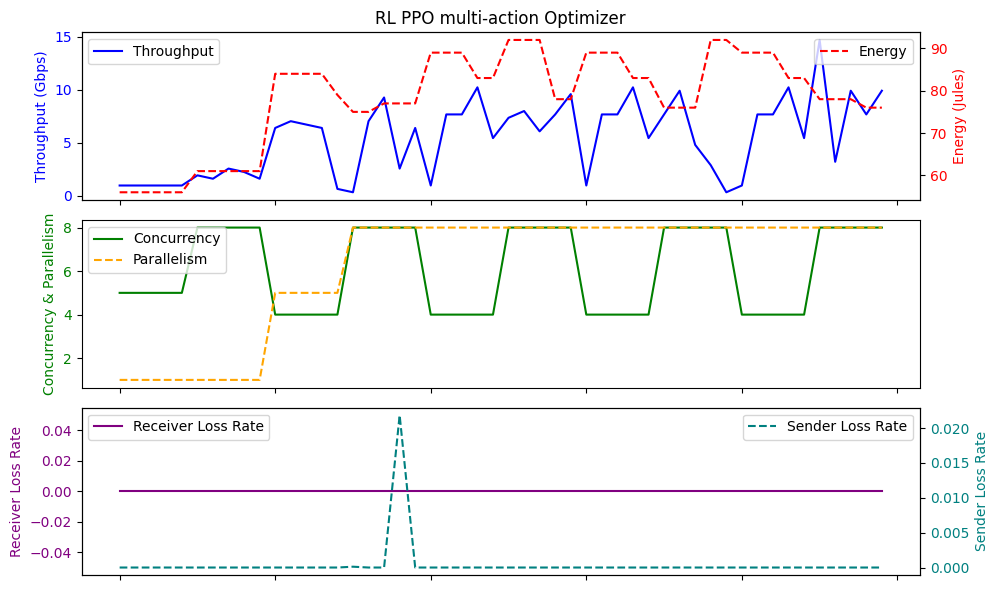

Average Throughput: 5.4656
Total Energy: 3910.0
Total loss rate: 0.02195865301731461
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.528000       0.0   6.022222  33.868889  79.733333   0.000660
std      2.885974       0.0   2.589216   2.632301   8.721447   0.003434
min      0.960000       0.0   1.000000  32.500000  60.000000   0.000000
25%      4.480000       0.0   4.000000  32.700000  77.000000   0.000000
50%      6.720000       0.0   6.000000  32.900000  83.000000   0.000000
75%      8.640000       0.0   8.000000  33.600000  84.000000   0.000000
max     14.720000       0.0  13.000000  44.300000  89.000000   0.021841
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [4.6, -1.9999999999999996, 3.4, 0.20000000000000018, -0.20000000000000018, 1.0, 0.59999999

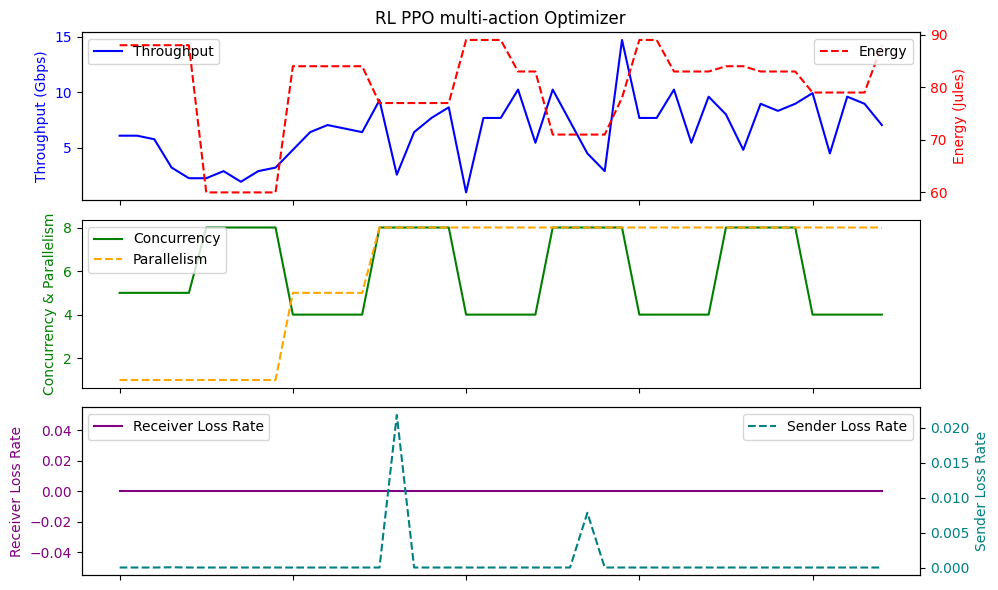

Average Throughput: 6.528000000000001
Total Energy: 3588.0
Total loss rate: 0.02971738429281865
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.520889       0.0   6.044444  33.524444  78.822222   0.000019
std      3.051301       0.0   2.820022   2.151126   9.376685   0.000128
min      1.280000       0.0   1.000000  32.500000  59.000000   0.000000
25%      4.480000       0.0   4.000000  32.600000  77.000000   0.000000
50%      7.040000       0.0   7.000000  32.800000  82.000000   0.000000
75%      8.960000       0.0   8.000000  33.200000  84.000000   0.000000
max     11.200000       0.0  11.000000  44.300000  93.000000   0.000859
Episode reward: 7.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.4, 1.0, 3.6, 1.2000000000000002, 0.20000000000000018, -1.0, 2.19999999999999

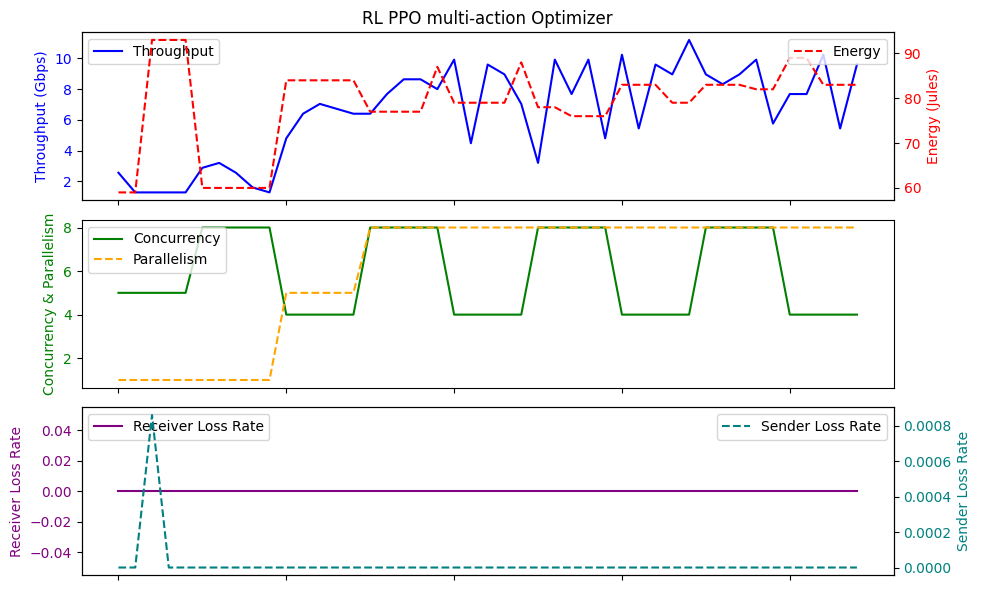

Average Throughput: 6.52088888888889
Total Energy: 3547.0
Total loss rate: 0.0008590213764165593
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   50.000000      50.0  50.000000  50.000000  50.000000  50.000000
mean     5.875200       0.0   5.400000  33.594000  76.120000   0.000854
std      3.722142       0.0   3.313547   1.984677  11.463589   0.004215
min      0.320000       0.0   0.000000  32.500000  50.000000   0.000000
25%      2.000000       0.0   2.000000  32.700000  75.500000   0.000000
50%      6.560000       0.0   6.000000  33.000000  79.000000   0.000000
75%      8.320000       0.0   8.000000  33.300000  83.000000   0.000000
max     13.440000       0.0  13.000000  44.300000  92.000000   0.021841
Episode reward: 7.4
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   10
rewards [1.0, 1.2000000000000002, 2.8, -1.6, 5.4, -2.200000000000001, 

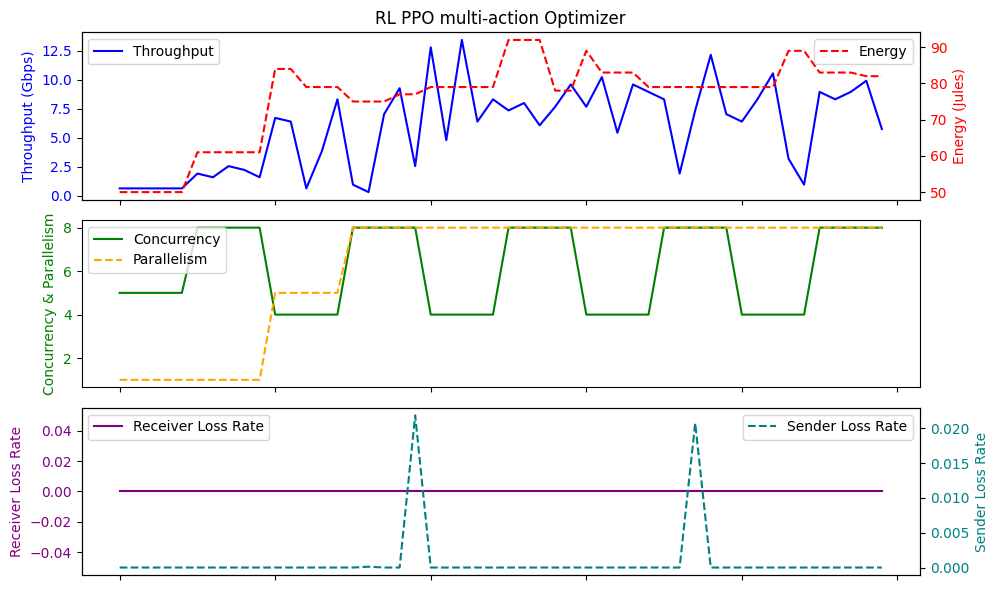

Average Throughput: 5.875200000000001
Total Energy: 3806.0
Total loss rate: 0.04269853699837446
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.286222       0.0   5.800000  33.735556  74.066667   0.000461
std      3.930542       0.0   3.468036   2.743518  11.348608   0.003092
min      0.640000       0.0   1.000000  32.500000  50.000000   0.000000
25%      1.920000       0.0   2.000000  32.600000  71.000000   0.000000
50%      7.040000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.300000  79.000000   0.000000
max     13.760000       0.0  13.000000  46.100000  89.000000   0.020740
Episode reward: 7.4
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 0.19999999999999996, 3.8, 3.4000000000000004, -0.40000000000000036, -1.79

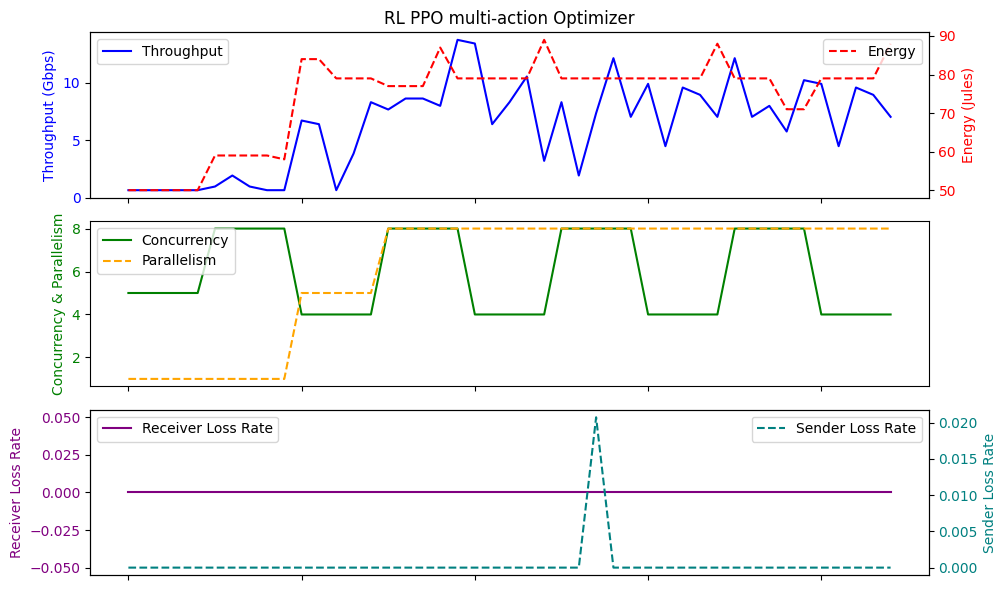

Average Throughput: 6.286222222222222
Total Energy: 3333.0
Total loss rate: 0.020739883981059852
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   50.000000      50.0  50.000000  50.000000  50.000000  50.000000
mean     5.836800       0.0   5.320000  34.510000  77.340000   0.001148
std      3.774993       0.0   3.316256   3.834231  12.068867   0.004273
min      0.640000       0.0   1.000000  32.500000  50.000000   0.000000
25%      2.080000       0.0   2.000000  32.700000  79.000000   0.000000
50%      6.880000       0.0   6.000000  32.900000  80.500000   0.000000
75%      8.320000       0.0   7.750000  33.500000  84.000000   0.000000
max     13.760000       0.0  12.000000  48.800000  89.000000   0.020740
Episode reward: 6.2
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   10
rewards [1.0, 1.0, 3.0, 2.2, -1.6000000000000005, 1.2000000000000002, 

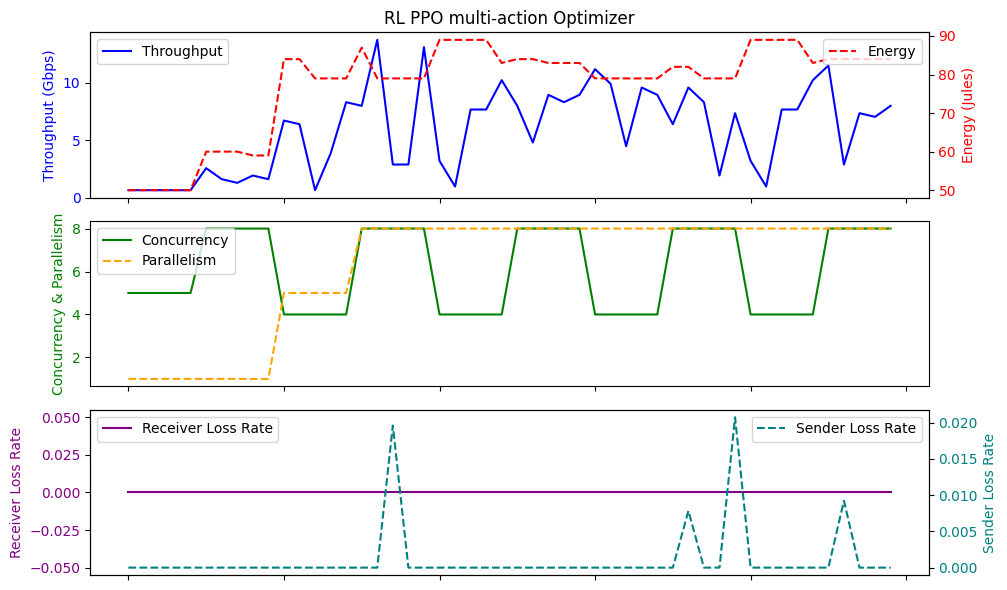

Average Throughput: 5.8368
Total Energy: 3867.0
Total loss rate: 0.057395400396315396
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.307556       0.0   5.844444  33.304444  77.600000   0.000379
std      3.045448       0.0   2.754794   1.794557   8.783766   0.001783
min      0.640000       0.0   1.000000  32.500000  59.000000   0.000000
25%      3.520000       0.0   3.000000  32.700000  77.000000   0.000000
50%      6.720000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.640000       0.0   8.000000  33.200000  84.000000   0.000000
max     13.440000       0.0  13.000000  44.300000  89.000000   0.009219
Episode reward: 8.0
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [3.2, -1.0, 2.5999999999999996, 2.4000000000000004, 0.20000000000000018, -0.4000000000000

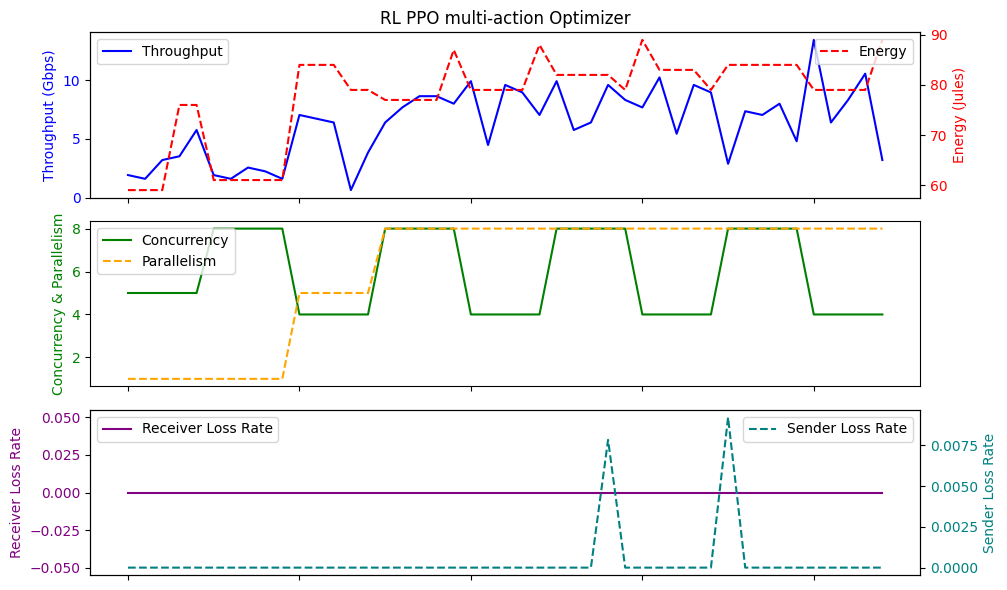

Average Throughput: 6.307555555555555
Total Energy: 3492.0
Total loss rate: 0.017055570113738563
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.350222       0.0   5.933333  33.733333  77.022222       0.0
std      3.702983       0.0   3.333030   2.220565   9.757256       0.0
min      0.640000       0.0   1.000000  32.500000  50.000000       0.0
25%      2.880000       0.0   3.000000  32.700000  78.000000       0.0
50%      6.720000       0.0   6.000000  33.100000  79.000000       0.0
75%      8.960000       0.0   8.000000  33.500000  83.000000       0.0
max     14.720000       0.0  13.000000  44.300000  89.000000       0.0
Episode reward: 6.0
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.0, 0.20000000000000018, 2.8, 2.8, 0.20000000000000018, -1.0, 1.5999999999999996, -1.

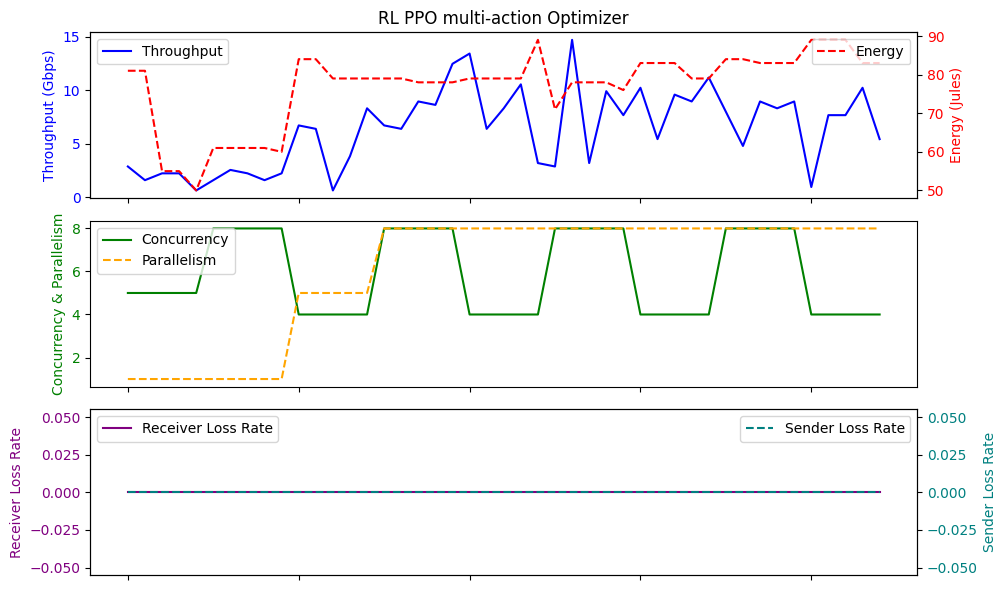

Average Throughput: 6.350222222222223
Total Energy: 3466.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.471111       0.0   5.844444  33.213333  79.533333   0.002012
std      3.147858       0.0   2.922915   0.985486   8.667075   0.009589
min      0.320000       0.0   0.000000  32.500000  60.000000   0.000000
25%      4.480000       0.0   3.000000  32.600000  77.000000   0.000000
50%      6.720000       0.0   6.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.300000  83.000000   0.000000
max     13.440000       0.0  13.000000  37.300000  97.000000   0.060738
Episode reward: 7.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.6, -0.20000000000000018, 3.6, -1.5999999999999996, 3.5999999999999996, -0.5999999999999996, 

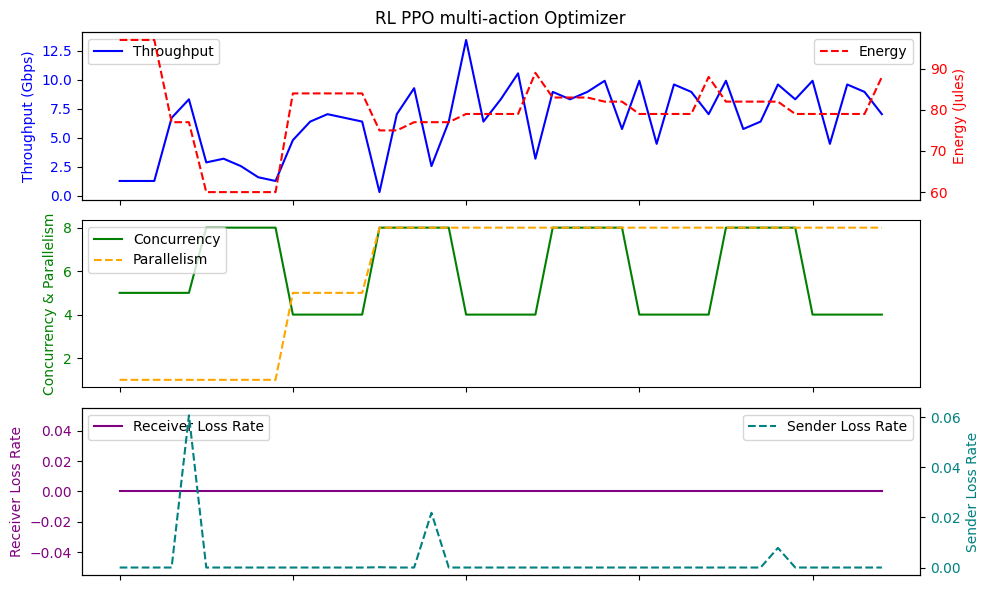

Average Throughput: 6.471111111111112
Total Energy: 3579.0
Total loss rate: 0.09053316169356865
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.286222       0.0   5.800000  33.935556  79.488889       0.0
std      3.352133       0.0   2.951117   3.009240   9.817939       0.0
min      0.640000       0.0   1.000000  32.600000  60.000000       0.0
25%      2.880000       0.0   3.000000  32.800000  78.000000       0.0
50%      7.360000       0.0   7.000000  33.000000  83.000000       0.0
75%      8.640000       0.0   8.000000  33.300000  84.000000       0.0
max     13.760000       0.0  12.000000  44.700000  92.000000       0.0
Episode reward: 5.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [4.0, -1.7999999999999998, 3.0, 3.2, -2.8000000000000007, 1.0, 1.2000000000000002, -1.0,

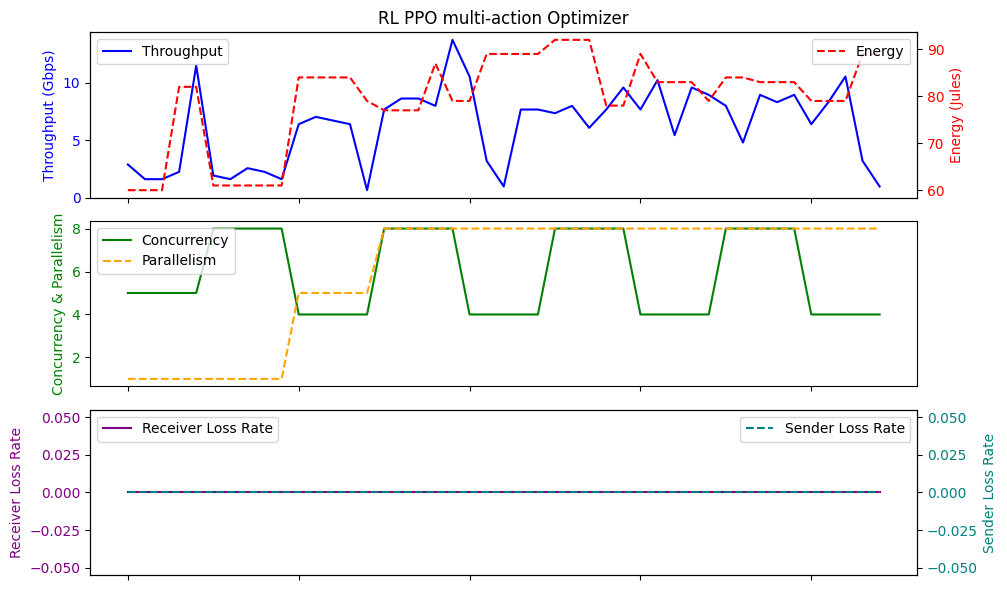

Average Throughput: 6.286222222222221
Total Energy: 3577.0
Total loss rate: 0.0
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.307556       0.0   5.777778  33.422222  77.622222   0.000455
std      3.255963       0.0   2.898972   1.947013   8.478017   0.002922
min      0.960000       0.0   1.000000  32.500000  60.000000   0.000000
25%      3.200000       0.0   3.000000  32.700000  76.000000   0.000000
50%      7.040000       0.0   7.000000  32.800000  79.000000   0.000000
75%      8.960000       0.0   8.000000  33.200000  84.000000   0.000000
max     13.760000       0.0  12.000000  44.700000  92.000000   0.019600
Episode reward: 7.4
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.2, 1.0000000000000002, 3.8, 1.4000000000000004, 0.0, -1.0, 1.0, -0.8000000000000007, 0.80000

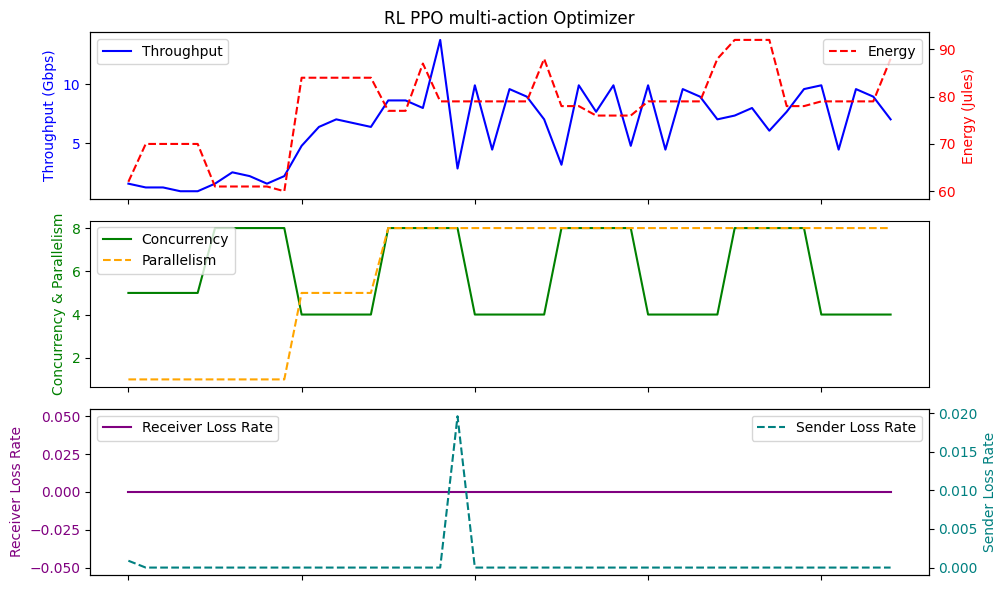

Average Throughput: 6.307555555555556
Total Energy: 3493.0
Total loss rate: 0.020485148254019574
       Throughput  LossRate      Score        RTT     Energy  SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000      45.0
mean     6.456889       0.0   6.022222  33.837778  80.777778       0.0
std      3.737598       0.0   3.454173   2.480679   9.565299       0.0
min      0.320000       0.0   0.000000  32.600000  61.000000       0.0
25%      2.880000       0.0   3.000000  32.800000  77.000000       0.0
50%      6.720000       0.0   6.000000  33.000000  79.000000       0.0
75%      8.960000       0.0   8.000000  33.400000  84.000000       0.0
max     13.760000       0.0  13.000000  44.700000  97.000000       0.0
Episode reward: 8.4
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [2.2, 0.0, 2.8, 3.4000000000000004, 0.1999999999999993, -2.1999999999999993, 2.40000000

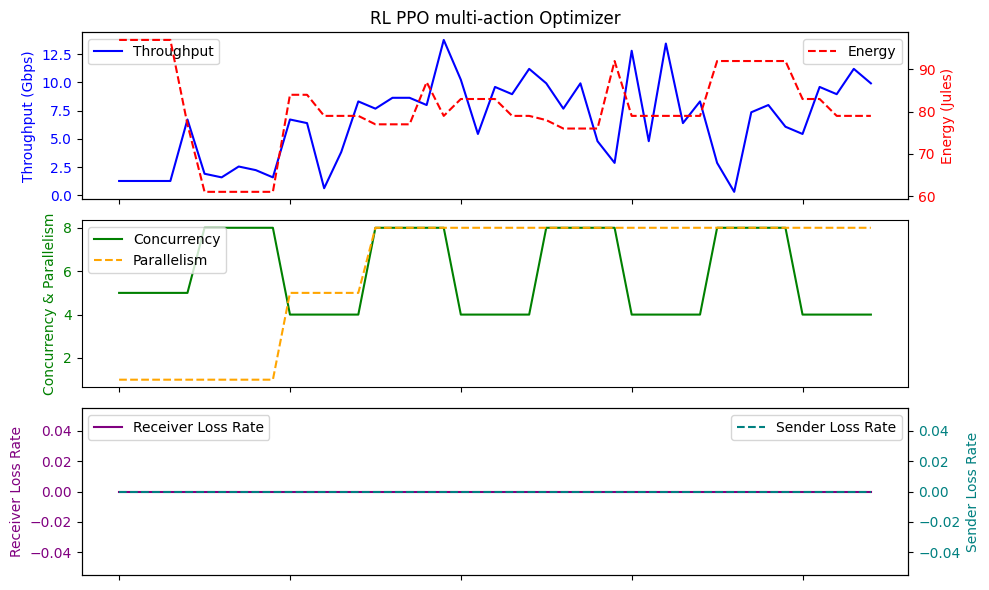

Average Throughput: 6.456888888888889
Total Energy: 3635.0
Total loss rate: 0.0
       Throughput  LossRate     Score        RTT     Energy   SenderLR
count   50.000000      50.0  50.00000  50.000000  50.000000  50.000000
mean     5.785600       0.0   5.30000  33.686000  78.080000   0.000596
std      3.469976       0.0   3.14448   2.243358   8.606689   0.003260
min      0.320000       0.0   0.00000  32.500000  59.000000   0.000000
25%      2.640000       0.0   3.00000  32.600000  75.000000   0.000000
50%      6.400000       0.0   6.00000  33.000000  79.000000   0.000000
75%      8.320000       0.0   8.00000  33.575000  84.000000   0.000000
max     13.440000       0.0  13.00000  46.100000  92.000000   0.021841
Episode reward: 7.2
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1])],   10
rewards [1.8, -0.40000000000000013, 4.6, -2.6, 2.4, -0.39999999999999947, 2.0, -0.80000000000000

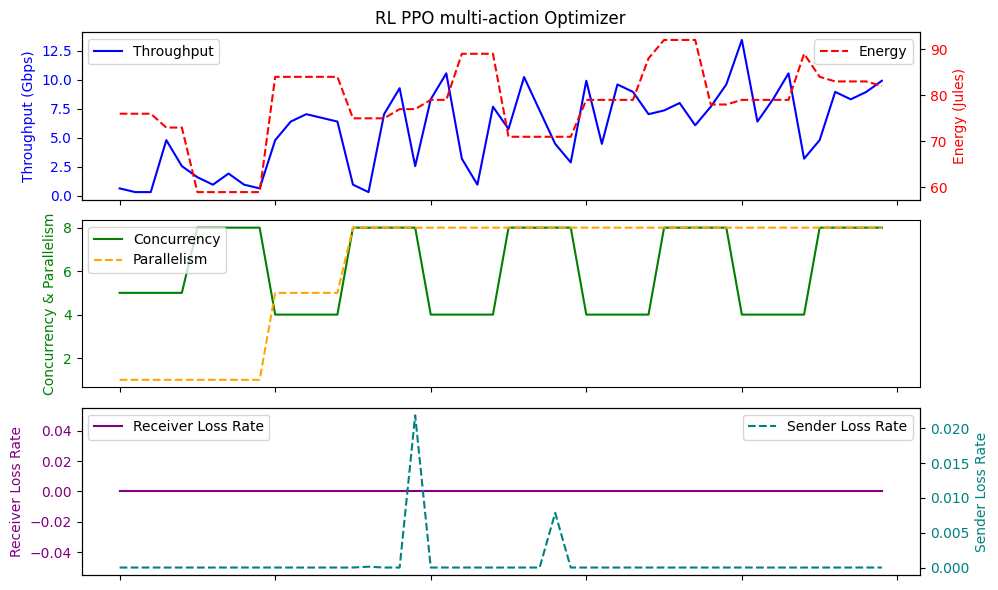

Average Throughput: 5.7856
Total Energy: 3904.0
Total loss rate: 0.029799916392896243
       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.058667       0.0   5.533333  34.255556  76.400000   0.001270
std      3.708914       0.0   3.327571   2.836896   9.587871   0.004549
min      0.640000       0.0   1.000000  32.500000  57.000000   0.000000
25%      1.920000       0.0   2.000000  32.600000  79.000000   0.000000
50%      6.720000       0.0   6.000000  33.000000  79.000000   0.000000
75%      8.960000       0.0   8.000000  34.000000  82.000000   0.000000
max     13.120000       0.0  12.000000  44.300000  89.000000   0.020740
Episode reward: 8.2
actions [array([4, 1]), array([3, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 0.6000000000000001, 4.4, 1.0, -1.4000000000000004, 1.0, 1.5999999999999996, -2.5999

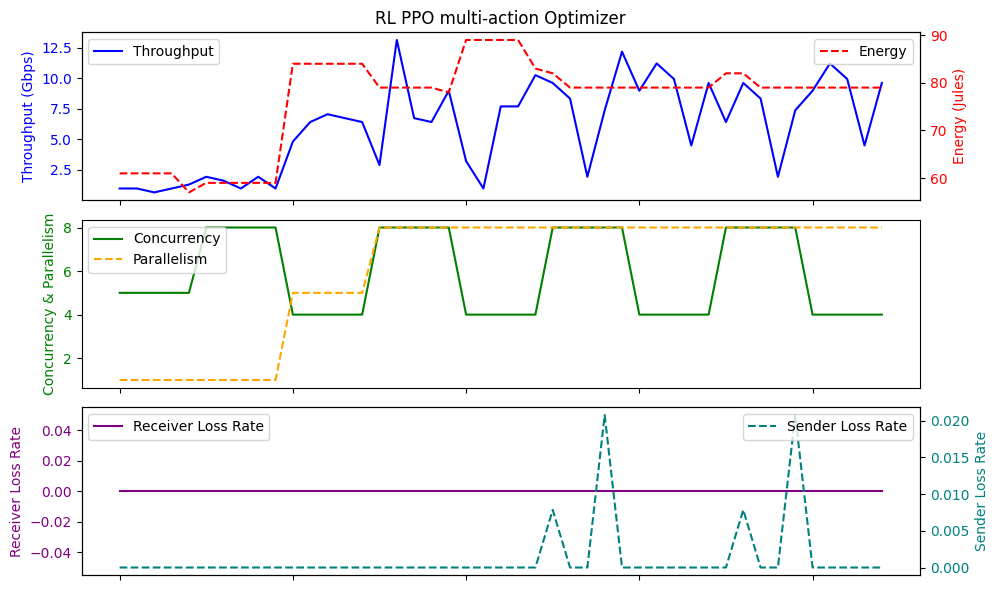

Average Throughput: 6.058666666666667
Total Energy: 3438.0
Total loss rate: 0.05715373108469286


In [10]:
######################################
############ RL
######################################
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

num_of_run=50

rl_2M_throughput_list=[]
rl_2M_energy_list=[]
rl_2M_plr_list=[]


model = PPO.load("./ppo_multi_action_in_de/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(action)
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    env.close()
    print(accumulator_df.describe())
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
#     print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
#     print(f"Total Energy {accumulator_df['Energy'].sum()}")
#     print(f"Total packet loss {accumulator_df['SenderLR'].sum()}")
    rl_2M_throughput_list.append(accumulator_df['Throughput'].mean())
    rl_2M_energy_list.append(accumulator_df['Energy'].sum())
    rl_2M_plr_list.append(accumulator_df['SenderLR'].sum())
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    df=accumulator_df.reset_index()
    # Top plot with Throughput and Energy
    ax1.plot( df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('RL PPO multi-action Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot( df['LossRate'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot( df['SenderLR'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
#     ax4_twin.set_ylim(-5,25)

#     ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
#     ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('withBT.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['SenderLR'].sum()
    print("Total loss rate:", total_plr)

{'Throughput': [[5.8112, 5.7856000000000005, 6.556444444444445, 6.08, 6.364444444444444, 6.492444444444445, 7.040000000000001, 6.549333333333332, 6.030222222222222, 6.193777777777778, 6.26488888888889, 5.824, 6.129777777777777, 6.300444444444444, 6.5760000000000005, 6.193777777777778, 6.151111111111112, 5.9448888888888884, 6.492444444444445, 6.0373333333333346, 6.044444444444444, 6.584888888888889, 6.222222222222222, 6.4, 6.037333333333334, 5.895111111111111, 6.1226666666666665, 6.129777777777777, 6.26488888888889, 6.492444444444444, 6.151111111111112, 6.6773333333333325, 6.544000000000001, 5.980444444444444, 6.357333333333334, 6.129777777777777, 5.4656, 6.528000000000001, 6.52088888888889, 5.875200000000001, 6.286222222222222, 5.8368, 6.307555555555555, 6.350222222222223, 6.471111111111112, 6.286222222222221, 6.307555555555556, 6.456888888888889, 5.7856, 6.058666666666667]], 'Energy': [[4001.0, 3943.0, 3528.0, 3627.0, 3506.0, 3577.0, 3168.0, 3582.0, 3489.0, 3559.0, 3366.0, 3485.0, 351

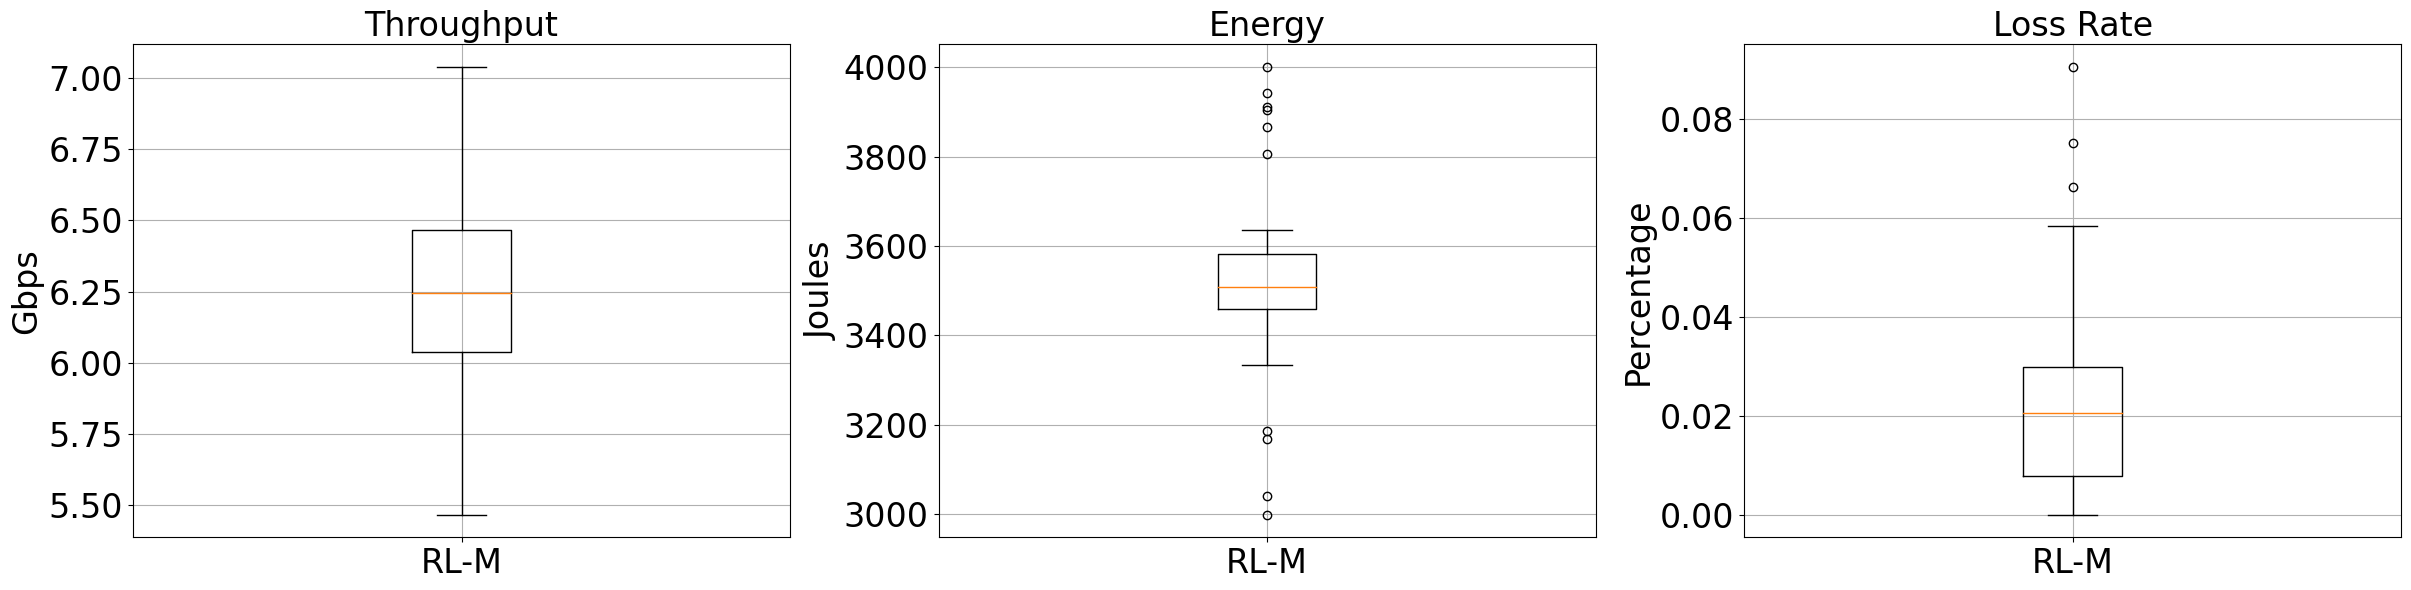

In [11]:
result_dictionary={"Throughput":[rl_2M_throughput_list],"Energy":[rl_2M_energy_list],"lossRate":[rl_2M_plr_list]}
print(result_dictionary)
import matplotlib.pyplot as plt

labels = ['RL-M']

# Assuming result_dictionary is already defined with the relevant data
# result_dictionary = {...}

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Font size for the ticks
tick_font_size = 24  # You can change this value as needed

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput',fontsize=24)
axes[0].set_ylabel('Gbps',fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[0].grid(True)  # Adding grid

# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy',fontsize=24)
axes[1].set_ylabel('Joules',fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate',fontsize=24)
axes[2].set_ylabel('Percentage',fontsize=24)
axes[2].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[2].grid(True)  # Adding grid

plt.tight_layout()
plt.show()
